# Incomes and Impact on Communicable Diseases

![Banner](./assets/graphic_banner.jpg)

## Topic

Looking at the spread of diseases is crucial to helping improve human health and well beings. Breaking down the Income and Disease numbers could help to provide some insight into how they correlate with one another. Diseases can become a very big problem very quickly. We got to see this play out during the chaos when Covid-19 was spreading around. Analyzing the impact between income and infections could hopefully draw more attention to situations like what happened with Covid-19. Addressing the spread of diseases is critical to saving lives across the globe and this problem will only continue to grow as diseases adapt and evolve overtime.

## Project Question



I want to specifically focus on how significant communicable diseases impact human health in different areas of income / around the globe. Being able to break down significant diseases and income datasets could allow for different correlations or patterns to be seen between the impact of these diseases and the income area they are associated in. Would we be able to draw potential conclusions from this data to help save lives or better address these diseases in different income areas? Focusig the data around locational data will provide me with some targeted data that I can break down to better answer the main question. 


## Approach and Analysis


This project is quite complex. I want to break down different communicable diseases and their impact on lower income countries. There are a lot of different ways to break this down so I wanted to focus on looking at the overall income of different countries and then comparing that to different disease cases, total deaths, and DALYs values to see how they impact different income communities. 

I wanted to focus on a few diseases such as cholera and measles from the WHO datasets first to see if I can establish a patter before working with the bigger sets of data. I then want to move on to the GBD data to get a better picture of the overall data and its impact. I want to analyze how the different statistics differ based on location and income to help correlate the data. 

I plan on doing this by almost breaking down the analysis and visualizations into different sections to help draw conclusions. I want to draw meaningful conclusions so I will do my best to provide accurate and meaningful visualizations. 

## Imports

In [2]:

import sys
assert sys.version_info >= (3, 10)

import numpy as np
import pandas as pd
import os


from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import (
  OneHotEncoder,
  StandardScaler
)
from sklearn.impute import (
  SimpleImputer
)

from sklearn.model_selection import (
  train_test_split,
)

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import (
  RandomForestClassifier, 
  GradientBoostingClassifier,
)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import geopandas as gpd

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.style.use("bmh")

## Data Sources

In [10]:
# Data Source 1
cholera_cases = pd.read_csv('Data/Cholera/cholera1_data.csv')
cholera_deaths = pd.read_csv('Data/Cholera/cholera2_data.csv')
measles_data = pd.read_csv('Data/OtherDiseases/measles_data.csv')

Data Source 1: WHO Data (Wide Range of Communicable Diseases Datasets - temporary)

    https://apps.who.int/gho/data/node.main
    
    The CSV's for WHO disease data are located in the OtherDisease folder in the Data folder. The primary focus will be cholera with some analytics towards other Diseases as well. 

In [11]:
# Data Source 2
income_cat = pd.read_csv('Data/Income/income_category.csv')

Data Source 2: Global Income Data

    https://datacatalog.worldbank.org/

    income_category.csv is a file that notes categorical income levels based off country

In [12]:
# Data Source 3
gbd_data_countries = pd.read_csv('Data/GBD/gbd_countries.csv')
income_grouping_data = pd.read_csv('Data/GBD/revised_world_bank_data.csv')

Data Source 3: IHME Global Burden of Disease (2019) Study

    https://www.healthdata.org/

    gbd_countries.csv is a dataset that includes country, year, type of disease, and number of deaths / DALYs

In [13]:
# Data Source 4
gbd_cd_data = pd.read_csv('Data/GBD/gbd_communicable_diseases.csv')

Data Source 4: Our World In Data

    https://ourworldindata.org/burden-of-disease

    gbd_communicable_diseases.csv is a refined dataset that includes the country, country code, year, and DALYs values

## Exploratory Data Analysis (EDA) & Visualizations

My goal is to breakdown how income correlates with communicable disease's impact one different countries. I first want to take a look at the income datasets to set a base to go off of.

### Income Information

In [14]:
display(income_cat.head(5))

,Economy,Code,Region,IncomeGroup
0,Aruba,ABW,Latin America & Caribbean,High income
1,Afghanistan,AFG,South Asia,Low income
2,Angola,AGO,Sub-Saharan Africa,Lower middle income
3,Albania,ALB,Europe & Central Asia,Upper middle income
4,Andorra,AND,Europe & Central Asia,High income


In [15]:
display(income_cat.shape)

(218, 4)

In [16]:
display(income_cat.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218 entries, 0 to 217
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Economy      218 non-null    object
 1   Code         218 non-null    object
 2   Region       218 non-null    object
 3   IncomeGroup  217 non-null    object
dtypes: object(4)
memory usage: 6.9+ KB


None

In [17]:
display(income_cat.isnull().sum())

Economy        0
Code           0
Region         0
IncomeGroup    1
dtype: int64

In [18]:
display(income_cat.describe())

,Economy,Code,Region,IncomeGroup
count,218,218,218,217
unique,218,218,7,4
top,Aruba,ABW,Europe & Central Asia,High income
freq,1,1,58,83


Since there are no huge outliers, duplicate values, or anomalies in the data we don't have to focus too much on cleaning the data. However, there is one missing value for the income group for income_category.csv. So I will focus on cleaning up that value.

In [19]:
income_cat_missing = income_cat[income_cat.isnull().any(axis=1)]
print(income_cat_missing)

           Economy Code                     Region IncomeGroup
207  Venezuela, RB  VEN  Latin America & Caribbean         NaN


The data comes with a note that lists the breakdown: 

This table classifies all World Bank member countries (189), and all other economies with populations of more than 30,000. For operational and analytical purposes, economies are divided among income groups according to 2022 gross national income (GNI) per capita, calculated using the World Bank Atlas method. The groups are: low income, $1,135 or less; lower middle income, $1,136  to $4,465; upper middle income, $4,466 to $13,845; and high income, $13,846 or more. The effective operational cutoff for IDA eligibility is $1,315 or less.

https://data.worldbank.org/indicator/NY.GNP.PCAP.CD?locations=VE

Venezuela's most recent value is listed at 13,010 putting in the upper middle income. 

In [20]:
missing_value = income_cat_missing.index[0]

income_cat.loc[missing_value, 'IncomeGroup'] = 'Upper middle income'

In [21]:
income_cat.isnull().sum()

Economy        0
Code           0
Region         0
IncomeGroup    0
dtype: int64

In [22]:
display(income_cat.value_counts('IncomeGroup'))

IncomeGroup
High income            83
Upper middle income    55
Lower middle income    54
Low income             26
Name: count, dtype: int64

<Axes: xlabel='IncomeGroup', ylabel='Count'>

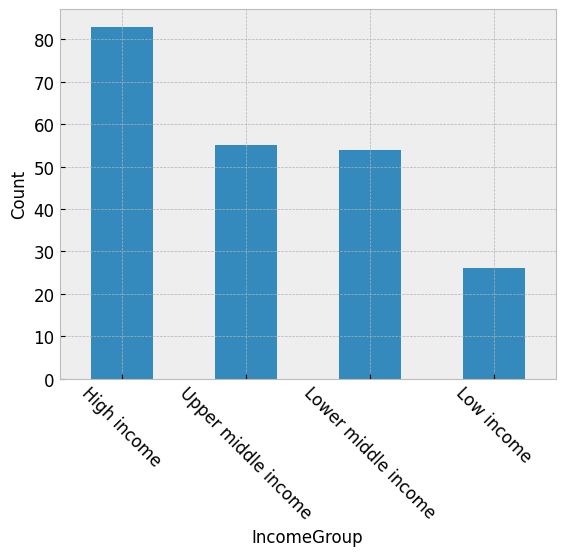

In [23]:
display(income_cat['IncomeGroup'].value_counts().plot(kind='bar', xlabel='IncomeGroup', ylabel='Count', rot=-45))

This graph includes general information of how many of each different income group there are

C:\Users\Kyle\AppData\Local\Temp\ipykernel_21584\2697129594.py:1: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



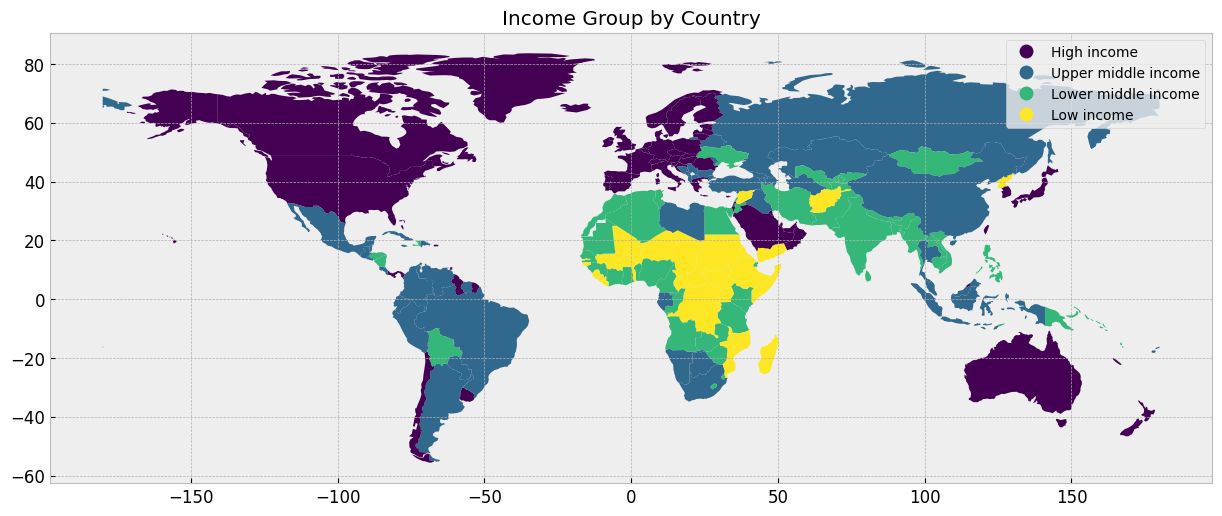

In [150]:
country_boundaries = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

merged_income_cat = country_boundaries.merge(income_cat, how='left', left_on='iso_a3', right_on='Code')

income_order = ['High income', 'Upper middle income', 'Lower middle income', 'Low income']
merged_income_cat['IncomeGroup'] = pd.Categorical(merged_income_cat['IncomeGroup'], categories=income_order, ordered=True)

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
merged_income_cat.plot(column='IncomeGroup', cmap='viridis', ax=ax, legend=True)
plt.title('Income Group by Country')
plt.show()

This is a geomap of the income grouping of each country. This project will explore how income impacts human life. Hopefully we will begin to see patterns emerge. Maybe countries indicated as low or lower middle income having a correlation with greater negative impact to human life. As we explore the diseases by country, we will be able to relate back to the income information throughout the project.

### Cholera Information

The two cholera datasets include different values for cases, deaths, and fatality rates. Instead of having them in two different datasets, I want to combine them. 

In [25]:
display(cholera_cases.head(5))
display(cholera_deaths.head(5))

,"Countries, territories and areas",Year,Number of reported cases of cholera
0,Afghanistan,2016,677
1,Afghanistan,2015,58064
2,Afghanistan,2014,45481
3,Afghanistan,2013,3957
4,Afghanistan,2012,12


,"Countries, territories and areas",Year,Number of reported deaths from cholera
0,Afghanistan,2016,5
1,Afghanistan,2015,8
2,Afghanistan,2014,4
3,Afghanistan,2013,14
4,Afghanistan,2012,0


In [26]:
cholera_data = pd.merge(cholera_cases, cholera_deaths, how='left', on=['Countries, territories and areas','Year'])

cholera_data.head()

,"Countries, territories and areas",Year,Number of reported cases of cholera,Number of reported deaths from cholera
0,Afghanistan,2016,677,5
1,Afghanistan,2015,58064,8
2,Afghanistan,2014,45481,4
3,Afghanistan,2013,3957,14
4,Afghanistan,2012,12,0


In [27]:
cholera_data.shape

(2469, 4)

In [28]:
cholera_data.isnull().sum()

Countries, territories and areas            0
Year                                        0
Number of reported cases of cholera         0
Number of reported deaths from cholera    116
dtype: int64

In [29]:
cholera_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2469 entries, 0 to 2468
Data columns (total 4 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   Countries, territories and areas        2469 non-null   object
 1   Year                                    2469 non-null   int64 
 2   Number of reported cases of cholera     2469 non-null   int64 
 3   Number of reported deaths from cholera  2353 non-null   object
dtypes: int64(2), object(2)
memory usage: 77.3+ KB


In [30]:
cholera_data.describe()

,Year,Number of reported cases of cholera
count,2469.000000,2469.000000
mean,1992.418388,3718.379101
std,14.838826,14904.906045
min,1949.000000,0.000000
25%,1981.000000,10.000000
50%,1994.000000,243.000000
75%,2005.000000,1892.000000
max,2016.000000,340311.000000


In [31]:
#To convert the object types to int64 after merging
cholera_data['Number of reported deaths from cholera'].replace('Unknown', np.nan, inplace=True)
cholera_data['Number of reported deaths from cholera'] = cholera_data['Number of reported deaths from cholera'].astype(float).astype('Int64')

In [32]:
cholera_data['Cholera case fatality rate'] = cholera_data['Number of reported deaths from cholera'] / cholera_data['Number of reported cases of cholera']

In [33]:
cholera_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2469 entries, 0 to 2468
Data columns (total 5 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Countries, territories and areas        2469 non-null   object 
 1   Year                                    2469 non-null   int64  
 2   Number of reported cases of cholera     2469 non-null   int64  
 3   Number of reported deaths from cholera  2352 non-null   Int64  
 4   Cholera case fatality rate              2352 non-null   Float64
dtypes: Float64(1), Int64(1), int64(2), object(1)
memory usage: 101.4+ KB


In [34]:
cholera_data.head()

,"Countries, territories and areas",Year,Number of reported cases of cholera,Number of reported deaths from cholera,Cholera case fatality rate
0,Afghanistan,2016,677,5,0.007386
1,Afghanistan,2015,58064,8,0.000138
2,Afghanistan,2014,45481,4,0.000088
3,Afghanistan,2013,3957,14,0.003538
4,Afghanistan,2012,12,0,0.0


In [35]:
cholera_data.describe()

,Year,Number of reported cases of cholera,Number of reported deaths from cholera,Cholera case fatality rate
count,2469.000000,2469.000000,2352.0,2352.0
mean,1992.418388,3718.379101,381.454507,<NA>
std,14.838826,14904.906045,3586.014473,<NA>
min,1949.000000,0.000000,0.0,<NA>
25%,1981.000000,10.000000,0.0,<NA>
50%,1994.000000,243.000000,7.0,<NA>
75%,2005.000000,1892.000000,60.0,<NA>
max,2016.000000,340311.000000,124227.0,<NA>


In [36]:
cholera_data.isnull().sum()

Countries, territories and areas            0
Year                                        0
Number of reported cases of cholera         0
Number of reported deaths from cholera    117
Cholera case fatality rate                117
dtype: int64

In [37]:
cholera_data_missing = cholera_data[cholera_data.isnull().any(axis=1)]
print(cholera_data_missing)

     Countries, territories and areas  Year  \
11                        Afghanistan  2002   
68                             Angola  1971   
77                          Australia  2015   
87                          Australia  2002   
88                          Australia  2001   
...                               ...   ...   
2330         United States of America  2002   
2331         United States of America  2001   
2356                         Viet Nam  2011   
2463                         Zimbabwe  1986   
2468                         Zimbabwe  1973   

      Number of reported cases of cholera  \
11                                      3   
68                                      1   
77                                      2   
87                                      5   
88                                      2   
...                                   ...   
2330                                    2   
2331                                    4   
2356                          

Since much of the missing data is just missing records from different years, I believe the best case would be to drop the rows that are not consistent across the data to help provide a better picture of the data. Most of the data is still available and I do not believe that dropping the rows will skew the data especially since we could look at years where all of the data is present across the graphs. 

In [38]:
cholera_data_prepared = cholera_data.dropna()

In [39]:
cholera_data_prepared.isnull().sum()

Countries, territories and areas          0
Year                                      0
Number of reported cases of cholera       0
Number of reported deaths from cholera    0
Cholera case fatality rate                0
dtype: int64

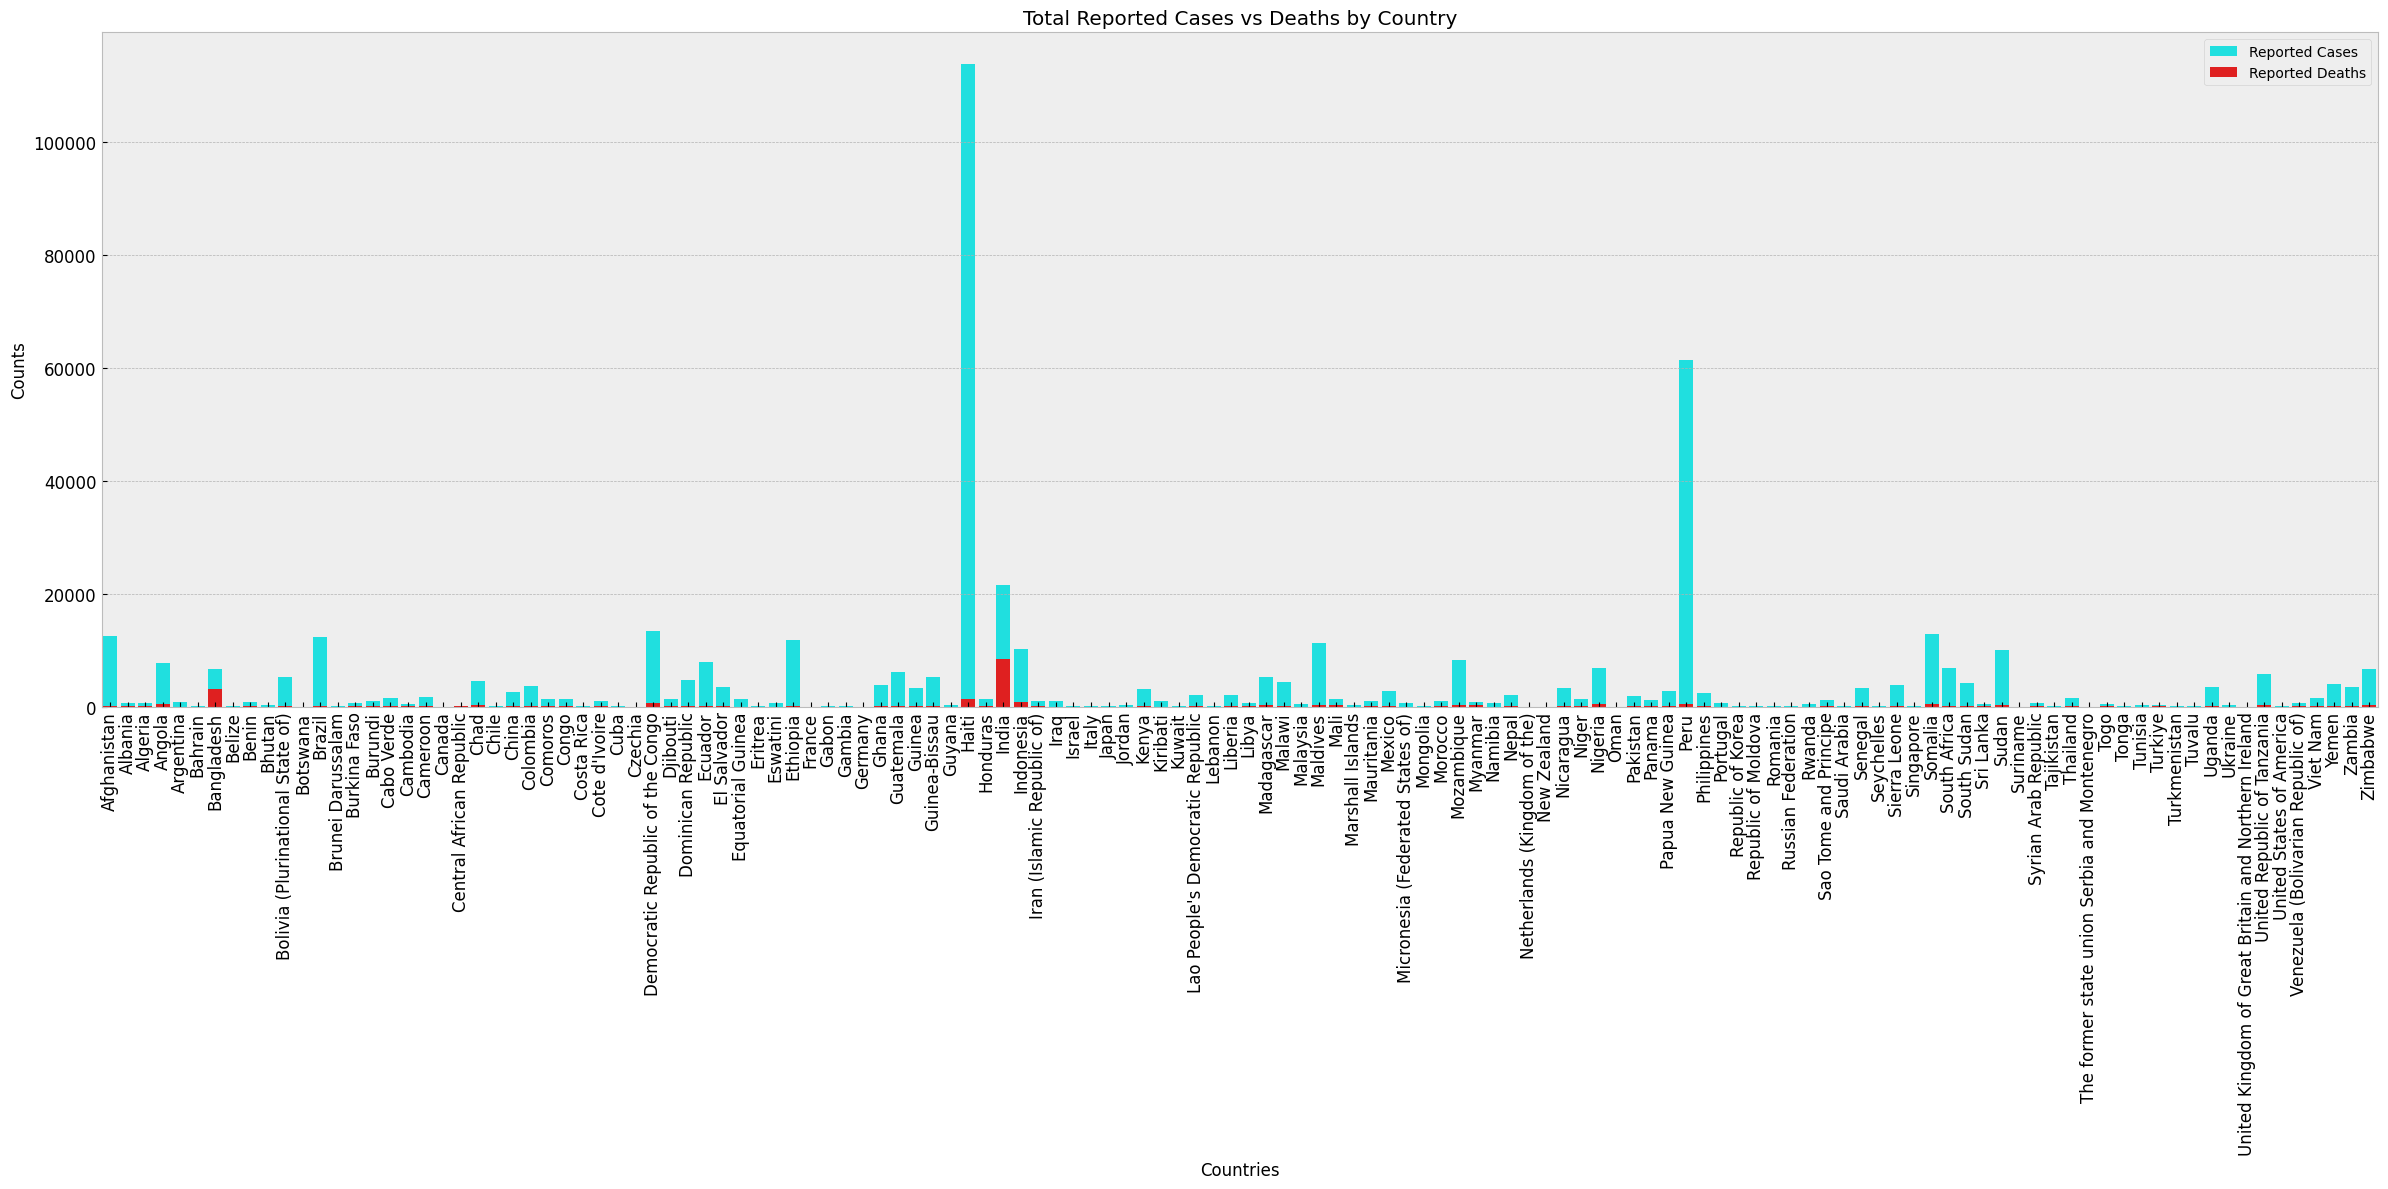

In [40]:
cholera_data_aggregated = cholera_data_prepared.groupby('Countries, territories and areas').agg({'Number of reported cases of cholera': 'mean','Number of reported deaths from cholera': 'mean'}).reset_index()
cholera_data_filtered = cholera_data_aggregated[(cholera_data_aggregated['Number of reported cases of cholera'] != 0) & (cholera_data_aggregated['Number of reported deaths from cholera'] != 0)]

plt.figure(figsize=(24, 12))


sns.barplot(x='Countries, territories and areas', y='Number of reported cases of cholera', data=cholera_data_filtered, label='Reported Cases', color='cyan')
sns.barplot(x='Countries, territories and areas', y='Number of reported deaths from cholera', data=cholera_data_filtered, label='Reported Deaths', color='red')
plt.xticks(rotation=90)
plt.xlabel('Countries')
plt.ylabel('Counts')
plt.title('Total Reported Cases vs Deaths by Country')
plt.legend()
plt.tight_layout()
plt.show()

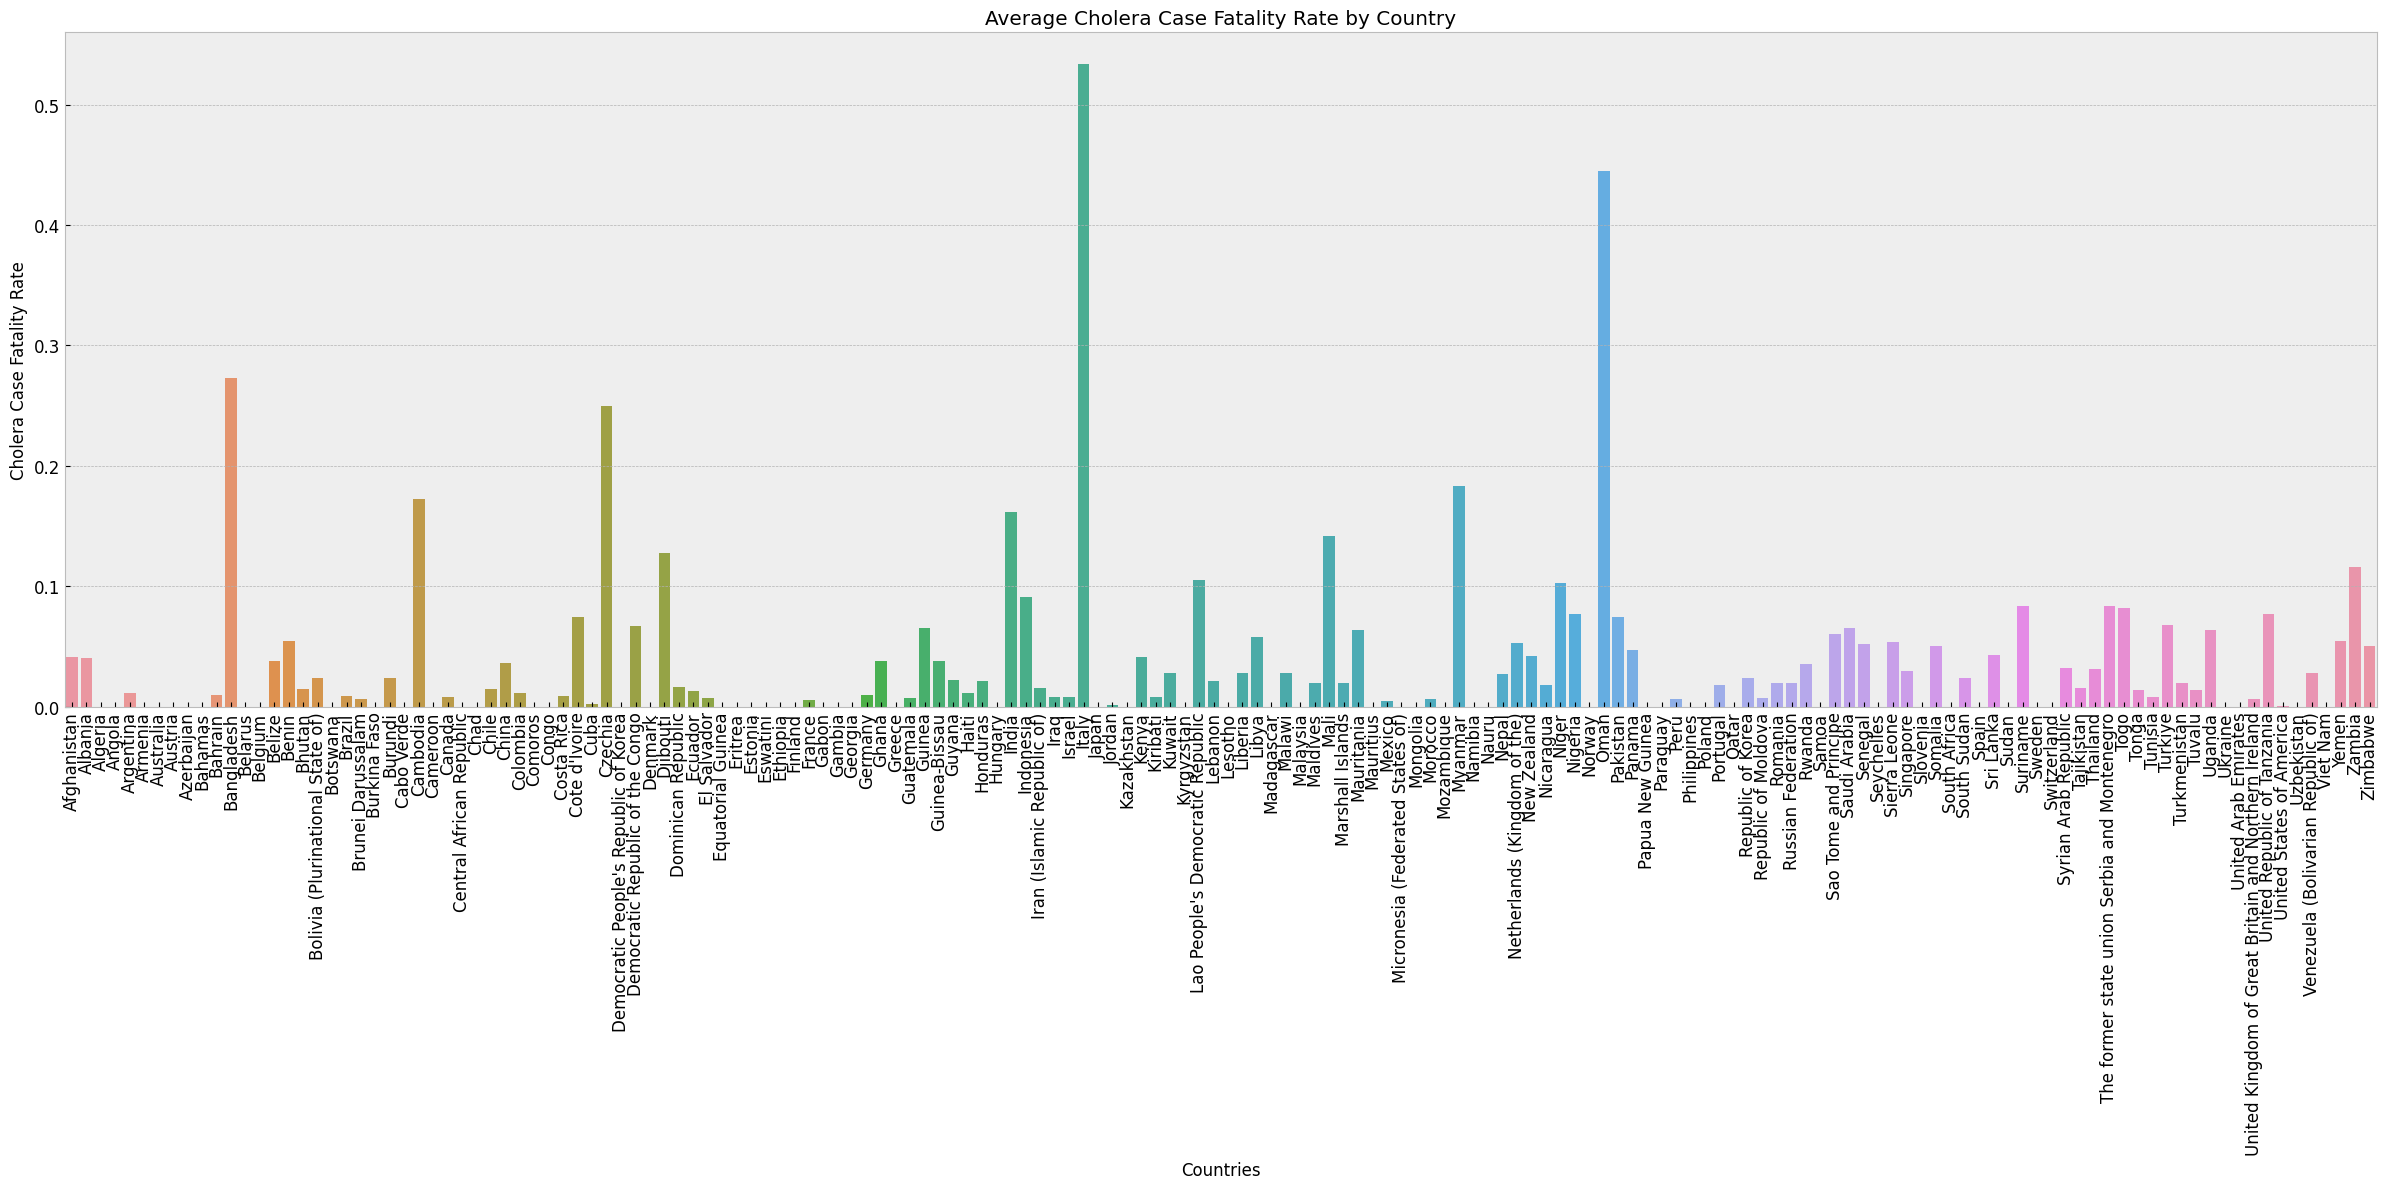

In [41]:
cholera_fatality_rate = cholera_data_prepared.groupby('Countries, territories and areas')['Cholera case fatality rate'].mean().reset_index()

plt.figure(figsize=(24, 12))
sns.barplot(x='Countries, territories and areas', y='Cholera case fatality rate', data=cholera_fatality_rate)
plt.xticks(rotation=90)
plt.xlabel('Countries')
plt.ylabel('Cholera Case Fatality Rate')
plt.title('Average Cholera Case Fatality Rate by Country')
plt.tight_layout()
plt.show()

These two graphs, while a bit crowded, do provide a lot of information. We see the two big outliers in graph one with Haiti and Peru having a large number of cases of Cholera. However, we do not see that translate to fatality rate. The second graph has Italy and Oman as the two outliers but they were not outliers on the first graph. It seems some of the data is skewed which may indicate some of the rates are off.

In [42]:
cholera_rate_outliers = cholera_data_prepared[cholera_data_prepared['Cholera case fatality rate'] > 1.0]
print(cholera_rate_outliers)

     Countries, territories and areas  Year  \
1093                            Italy  1998   

      Number of reported cases of cholera  \
1093                                    2   

      Number of reported deaths from cholera  Cholera case fatality rate  
1093                                       9                         4.5  


In [43]:
cholera_data_prepared.drop(index=1093, inplace=True)

C:\Users\Kyle\AppData\Local\Temp\ipykernel_21584\1756000292.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cholera_data_prepared.drop(index=1093, inplace=True)


In [44]:
cholera_rate_outliers = cholera_data_prepared[cholera_data_prepared['Cholera case fatality rate'] > 1.0]
print(cholera_rate_outliers)

Empty DataFrame
Columns: [Countries, territories and areas, Year, Number of reported cases of cholera, Number of reported deaths from cholera, Cholera case fatality rate]
Index: []


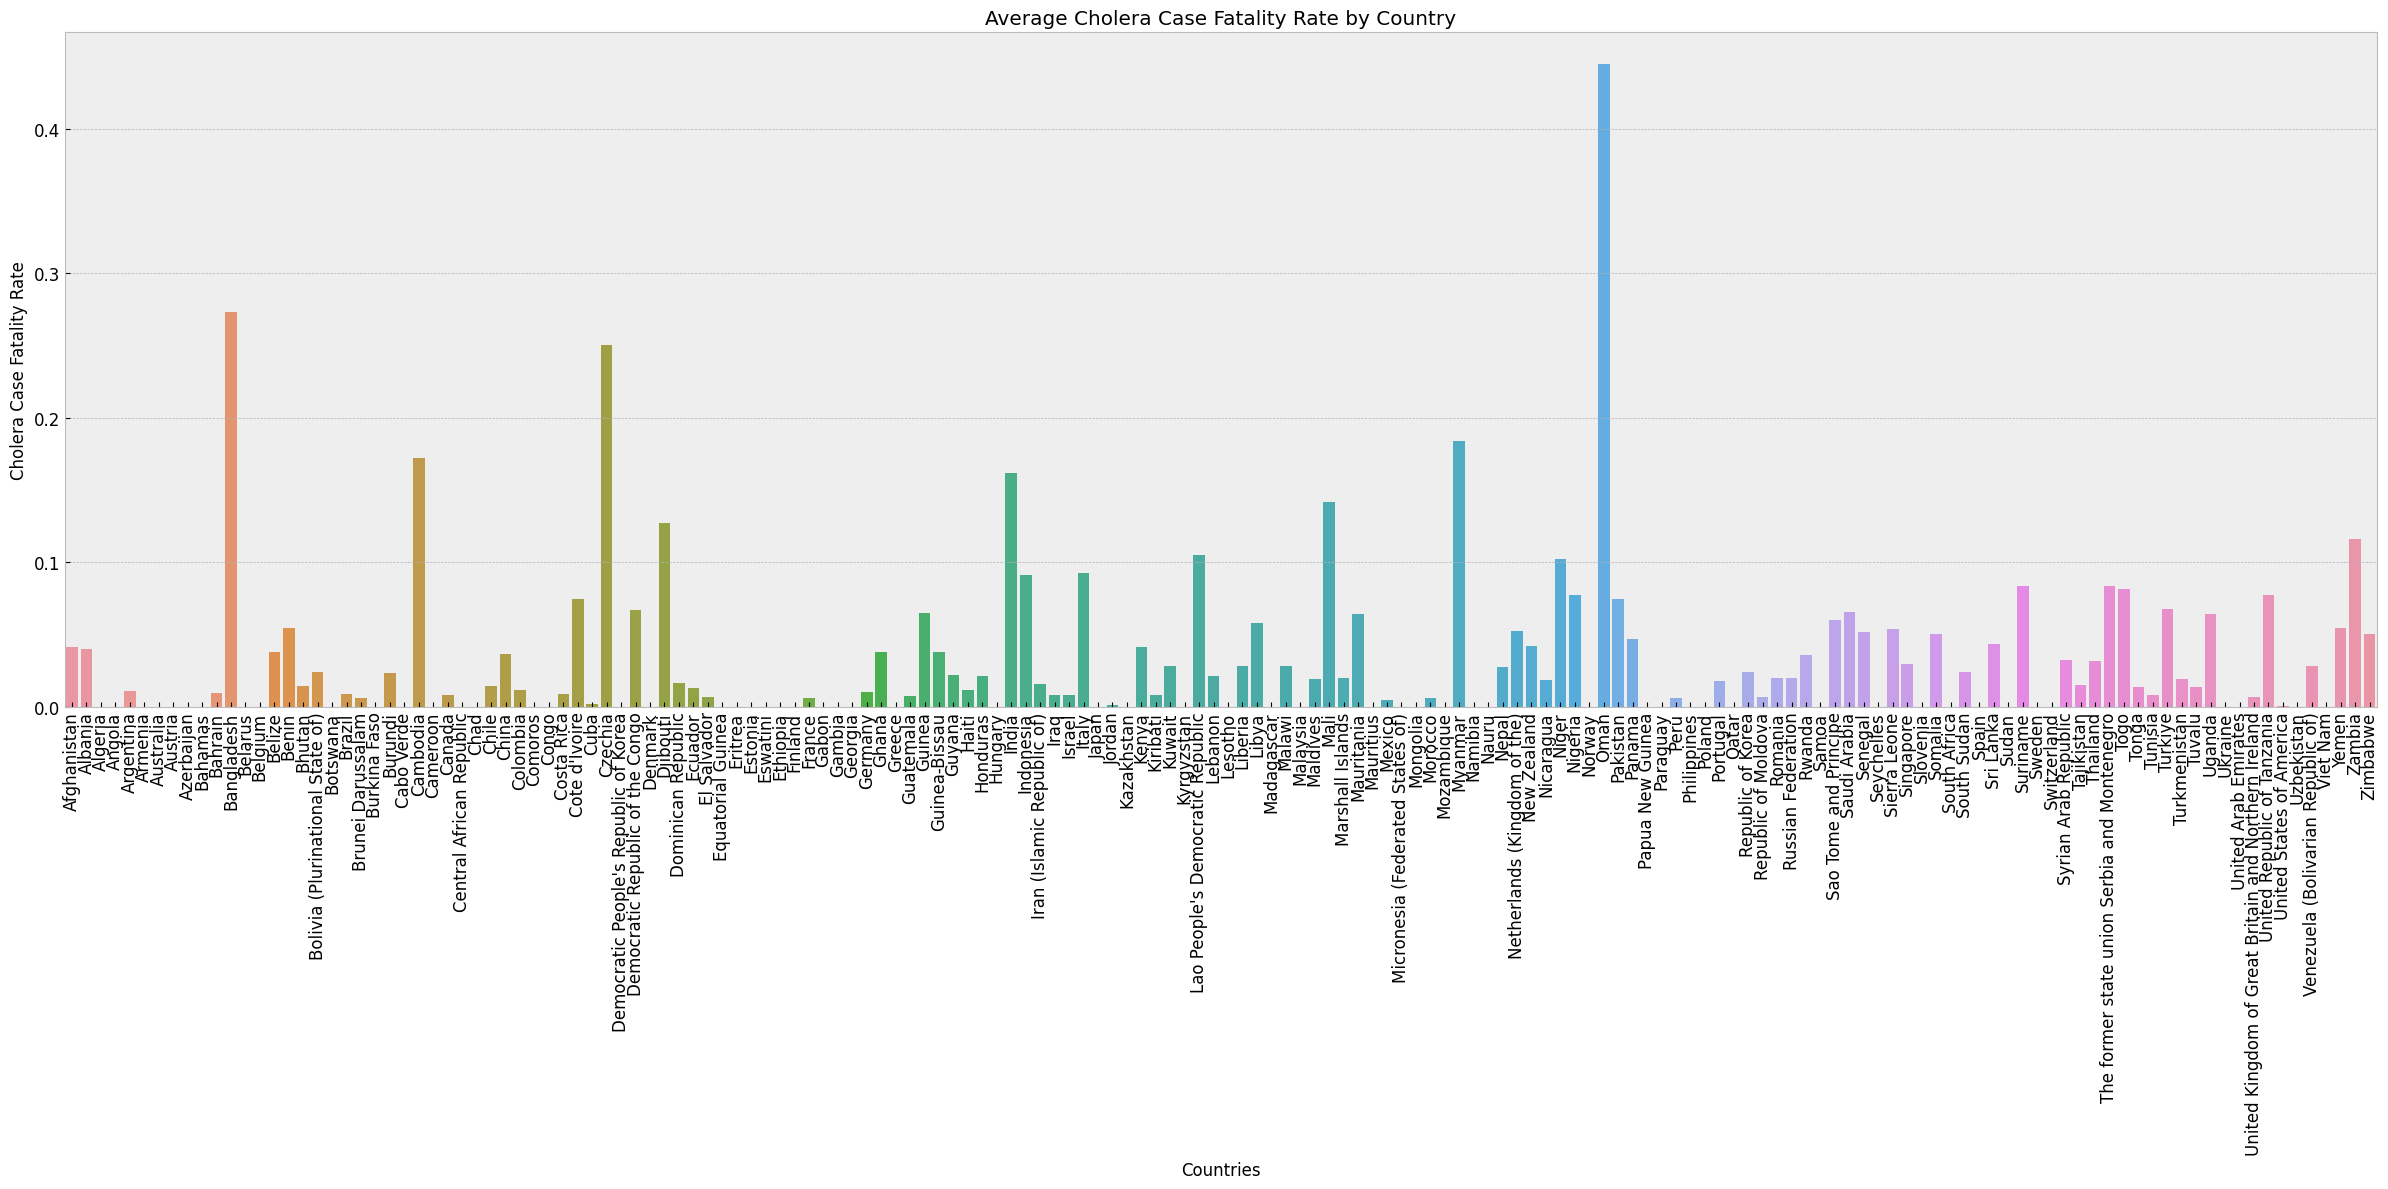

In [45]:
cholera_fatality_rate = cholera_data_prepared.groupby('Countries, territories and areas')['Cholera case fatality rate'].mean().reset_index()

plt.figure(figsize=(24, 12))
sns.barplot(x='Countries, territories and areas', y='Cholera case fatality rate', data=cholera_fatality_rate)
plt.xticks(rotation=90)
plt.xlabel('Countries')
plt.ylabel('Cholera Case Fatality Rate')
plt.title('Average Cholera Case Fatality Rate by Country')
plt.tight_layout()
plt.show()

Italy is no longer visualized on the graph

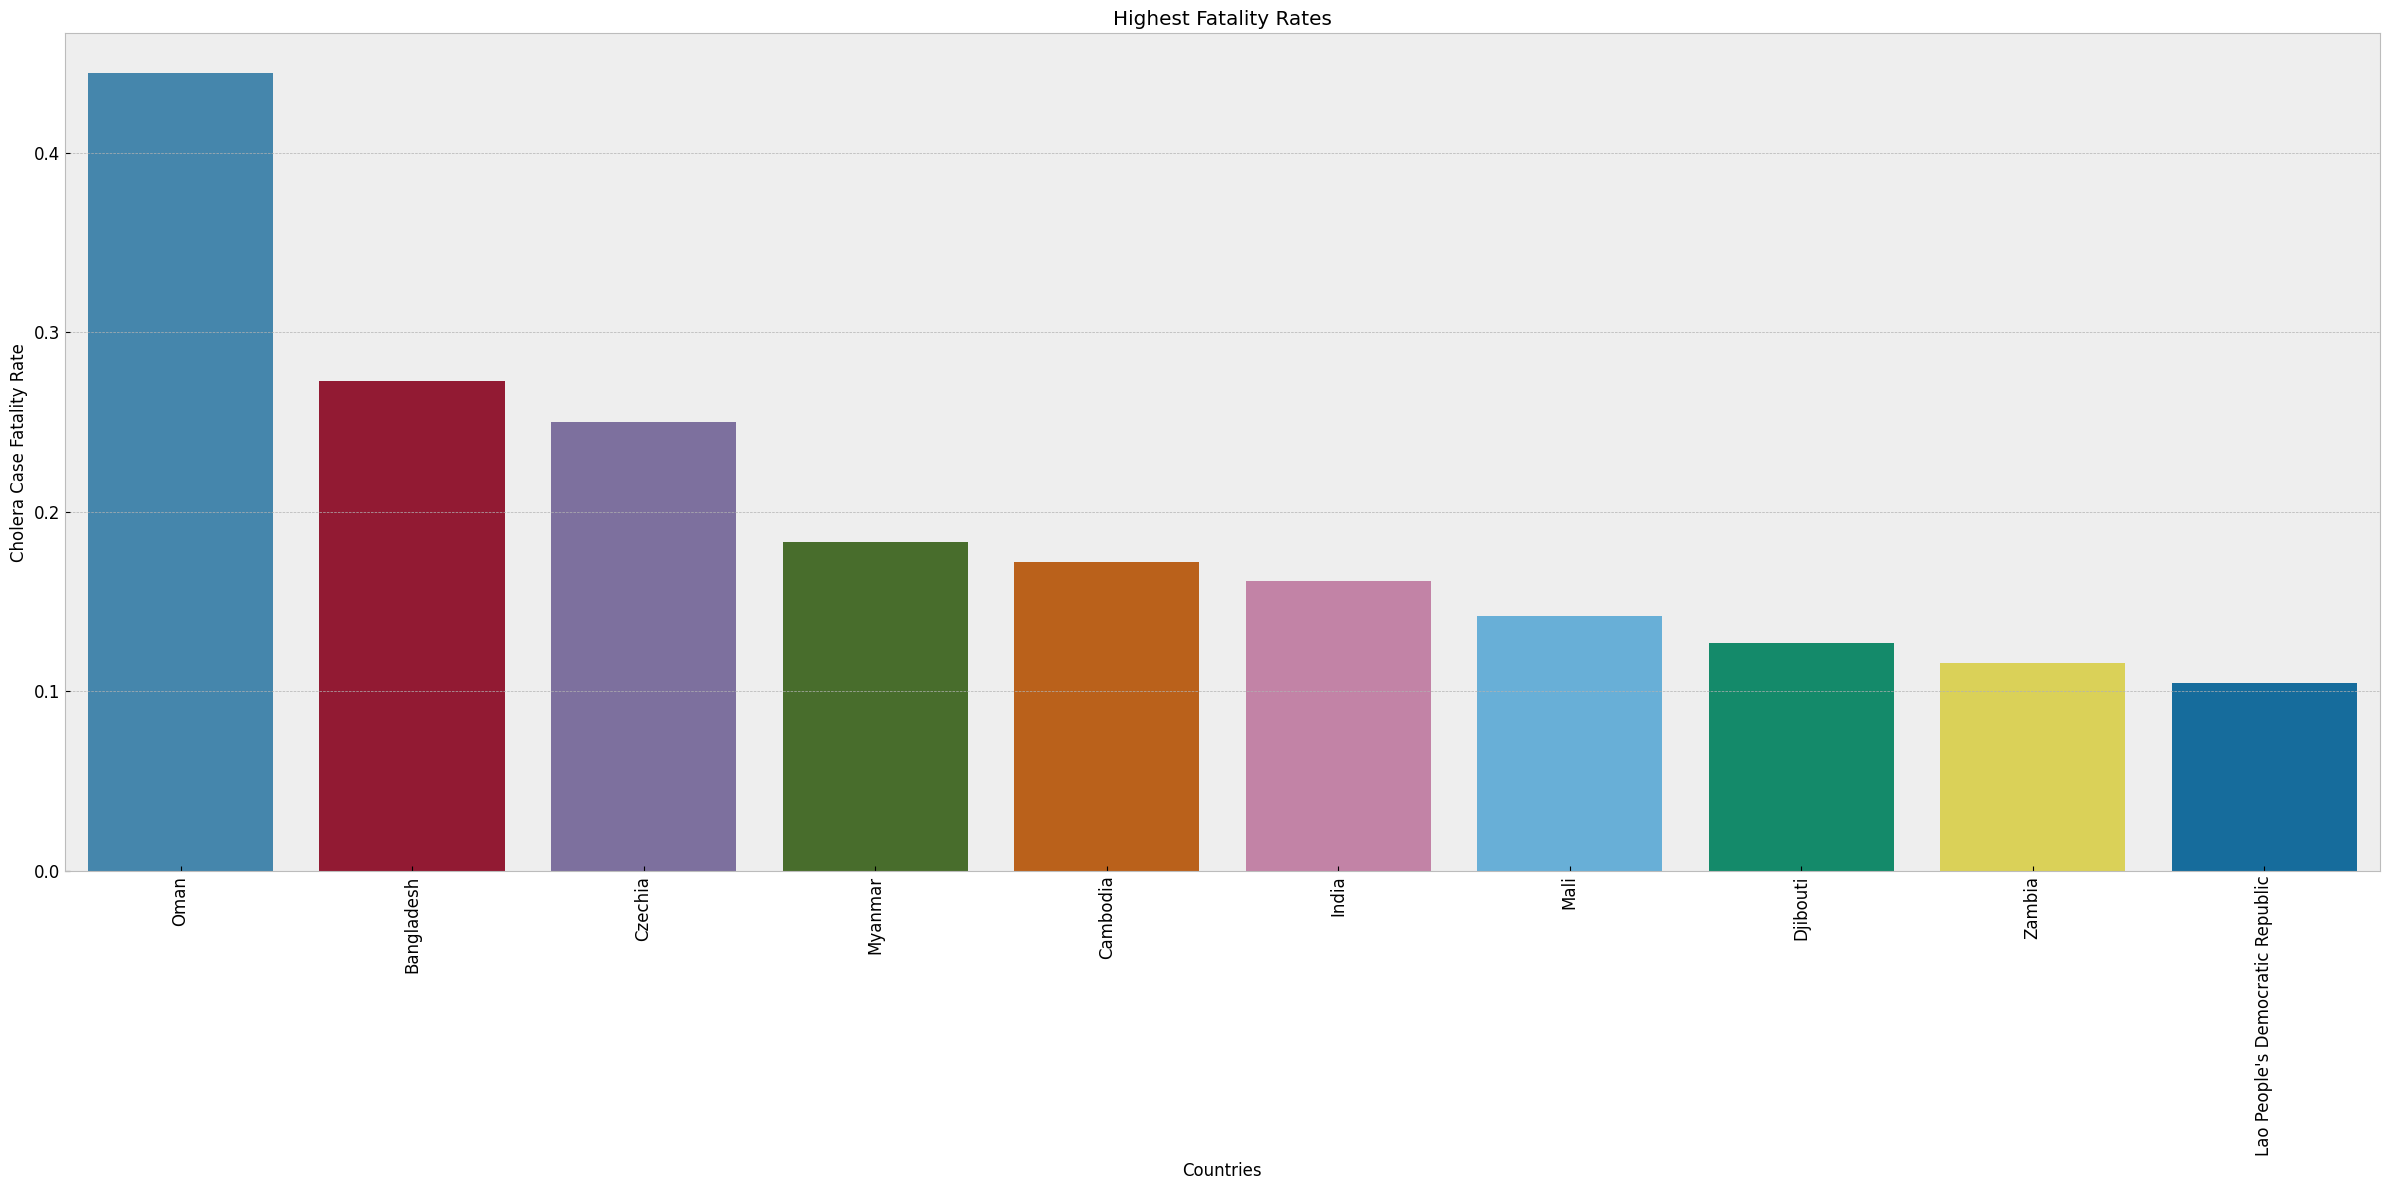

In [46]:
cholera_rate_sort = cholera_fatality_rate.sort_values(by='Cholera case fatality rate', ascending=False)
cholera_highest_fatality_rate = cholera_rate_sort.nlargest(10, 'Cholera case fatality rate')

plt.figure(figsize=(24, 12))
sns.barplot(x='Countries, territories and areas', y='Cholera case fatality rate', data=cholera_highest_fatality_rate)
plt.xticks(rotation=90)
plt.xlabel('Countries')
plt.ylabel('Cholera Case Fatality Rate')
plt.title('Highest Fatality Rates')
plt.tight_layout()
plt.show()

I wanted to see the top countries with the highest fatality rates and then will see how they line up with the income groupings.

In [47]:
countries_check = ['Oman', 'Bangladesh', 'Czechia', 'Myanmar', 'Cambodia', 'India', 'Mali', 'Djibouti', 'Zambia', 'Lao PDR']

for country in countries_check:
    country_rate_check = income_cat[income_cat['Economy'] == country][['Economy', 'IncomeGroup']]
    print(country_rate_check)

    Economy  IncomeGroup
149    Oman  High income
       Economy          IncomeGroup
17  Bangladesh  Lower middle income
    Economy  IncomeGroup
49  Czechia  High income
     Economy          IncomeGroup
130  Myanmar  Lower middle income
      Economy          IncomeGroup
102  Cambodia  Lower middle income
   Economy          IncomeGroup
89   India  Lower middle income
    Economy IncomeGroup
128    Mali  Low income
     Economy          IncomeGroup
51  Djibouti  Lower middle income
    Economy          IncomeGroup
216  Zambia  Lower middle income
     Economy          IncomeGroup
107  Lao PDR  Lower middle income


In [48]:
cholera_highest_fatality_rate = cholera_rate_sort.nlargest(62, 'Cholera case fatality rate')

highest_rates = cholera_highest_fatality_rate['Countries, territories and areas'].tolist()

filtered_countries = income_cat[income_cat['Economy'].isin(highest_rates)][['Economy', 'IncomeGroup']]

income_group_count = filtered_countries['IncomeGroup'].value_counts()

print(income_group_count)

IncomeGroup
Lower middle income    19
Low income             14
High income             9
Upper middle income     8
Name: count, dtype: int64


<Axes: xlabel='IncomeGroup', ylabel='Count'>

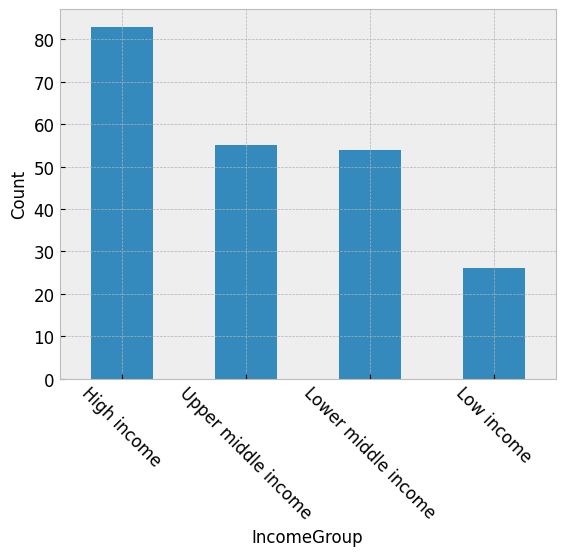

In [49]:
#Overall Income Categories
display(income_cat['IncomeGroup'].value_counts().plot(kind='bar', xlabel='IncomeGroup', ylabel='Count', rot=-45))

This is the total count of income groups included in the income_cat dataset

<Axes: xlabel='IncomeGroup', ylabel='Count'>

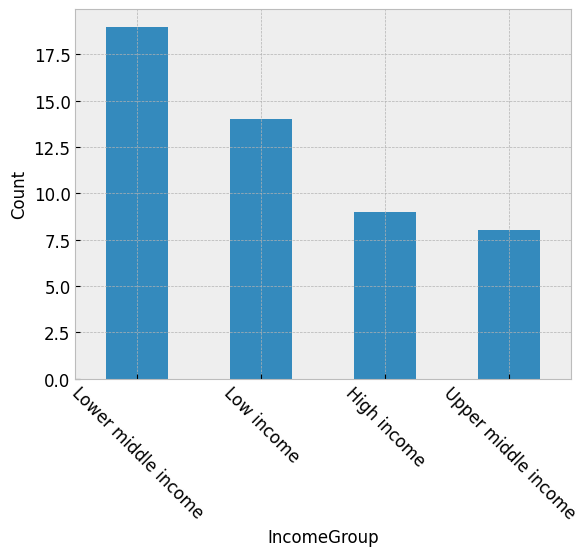

In [50]:
display(income_group_count.plot(kind='bar', xlabel='IncomeGroup', ylabel='Count', rot=-45))

There are some missing values due to the differences in the dataset with some countries not being listed between the two datasets. However, we can see from the original IncomeGroup graph compared to the one revised based off of the fatality rates that there is a significance that the fatality rate plays on the income grouping. 

The original income group has 63.3% in the Upper middle income and High income categories.
The top 50 country matches between fatality rate and income_cat has only 34% in the Upper middle income and High income categories. 

<Figure size 1600x1200 with 0 Axes>

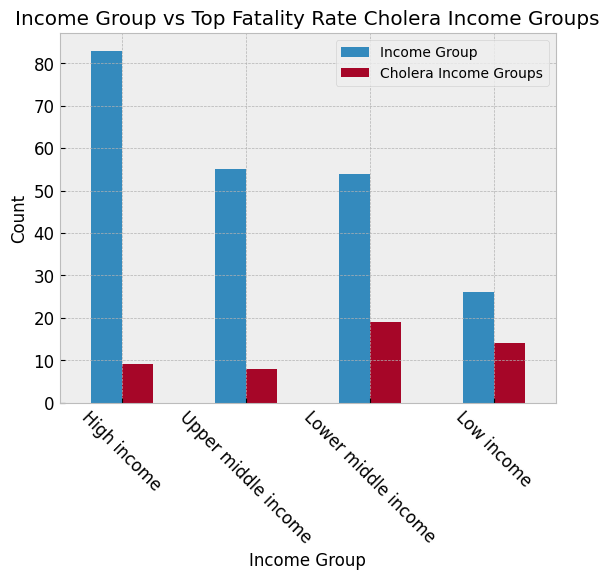

In [90]:
sorted_income_cat = income_cat['IncomeGroup'].value_counts().sort_index()
sorted_income_group_count = income_group_count.sort_index()

combined_income_group = pd.DataFrame({
    'Income Cat': sorted_income_cat,
    'Income Group Count': sorted_income_group_count
})

income_group_order = ['High income', 'Upper middle income', 'Lower middle income', 'Low income']
combined_income_group = combined_income_group.reindex(income_group_order)

plt.figure(figsize=(16, 12)) 
ax = combined_income_group.plot(kind='bar', xlabel='Income Group', ylabel='Count', rot=-45)
plt.xlabel('Income Group')
plt.ylabel('Count')
plt.title('Income Group vs Top Fatality Rate Cholera Income Groups')
ax.legend(['Income Group', 'Cholera Income Groups'])
plt.show()


### Measeles Data

In [73]:
measles_data.head()

,"Countries, territories and areas",2022,2021,2020,2019,2018,2017,2016,2015,2014,...,1983,1982,1981,1980,1979,1978,1977,1976,1975,1974
0,Afghanistan,5166.0,2900.0,640.0,353.0,2012.0,1511.0,638.0,1154.0,492.0,...,18808.0,20320.0,31107.0,32455.0,43979.0,43964.0,28174.0,26.0,466.0,7.0
1,Albania,1.0,NaN,4.0,488.0,1469.0,12.0,17.0,NaN,NaN,...,17.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Algeria,47.0,NaN,NaN,2585.0,3356.0,112.0,41.0,63.0,0.0,...,22126.0,29584.0,20849.0,15527.0,14937.0,10696.0,12015.0,15646.0,8899.0,10517.0
3,Andorra,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Angola,3271.0,300.0,1085.0,2987.0,57.0,29.0,53.0,119.0,11699.0,...,22589.0,30067.0,19714.0,29656.0,19682.0,20408.0,12940.0,5492.0,2153.0,5881.0


In [74]:
measles_data.shape

(195, 50)

In [75]:
measles_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 50 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Countries, territories and areas  195 non-null    object 
 1   2022                              165 non-null    float64
 2   2021                              165 non-null    float64
 3   2020                              163 non-null    float64
 4   2019                              186 non-null    float64
 5   2018                              188 non-null    float64
 6   2017                              186 non-null    float64
 7   2016                              179 non-null    float64
 8   2015                              177 non-null    float64
 9   2014                              170 non-null    float64
 10  2013                              176 non-null    float64
 11  2012                              189 non-null    float64
 12  2011    

In [76]:
measles_data.isnull().sum()

Countries, territories and areas     0
2022                                30
2021                                30
2020                                32
2019                                 9
2018                                 7
2017                                 9
2016                                16
2015                                18
2014                                25
2013                                19
2012                                 6
2011                                 6
2010                                 5
2009                                 7
2008                                12
2007                                 9
2006                                12
2005                                13
2004                                 5
2003                                13
2002                                17
2001                                19
2000                                25
1999                                27
1998                     

In [77]:
measles_data.describe()

,2022,2021,2020,2019,2018,2017,2016,2015,2014,2013,...,1983,1982,1981,1980,1979,1978,1977,1976,1975,1974
count,165.000000,165.000000,163.000000,186.000000,188.000000,186.000000,179.000000,177.000000,170.000000,176.000000,...,156.000000,156.000000,1.550000e+02,1.480000e+02,1.480000e+02,1.480000e+02,1.440000e+02,1.460000e+02,1.270000e+02,1.290000e+02
mean,1243.036364,746.575758,982.049080,4694.892473,1916.468085,932.903226,740.167598,1213.604520,1659.282353,1564.244318,...,22987.826923,23229.217949,2.631261e+04,2.602866e+04,3.069684e+04,3.578576e+04,4.056812e+04,3.680995e+04,3.921996e+04,4.340108e+04
std,4620.174495,4500.049929,6531.788464,29418.419929,7339.251859,4063.847720,3478.025966,4818.599152,7099.284545,8095.074515,...,74014.830288,78320.717820,8.835866e+04,9.640582e+04,1.437589e+05,1.975027e+05,2.224316e+05,2.131146e+05,2.278015e+05,2.885619e+05
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,469.500000,631.750000,2.955000e+02,5.437500e+02,5.312500e+02,3.737500e+02,9.005000e+02,6.230000e+02,4.765000e+02,5.380000e+02
50%,6.000000,1.000000,11.000000,65.000000,28.000000,11.000000,8.000000,18.000000,29.500000,15.500000,...,3242.500000,3831.500000,4.586000e+03,4.610000e+03,4.556500e+03,3.355500e+03,5.442500e+03,4.723500e+03,3.636000e+03,3.906000e+03
75%,212.000000,52.000000,281.000000,1069.500000,510.000000,162.500000,111.500000,212.000000,339.750000,231.000000,...,17253.250000,18192.750000,2.111650e+04,2.395800e+04,2.034525e+04,1.916525e+04,2.299400e+04,2.309175e+04,1.996300e+04,2.209400e+04
max,40967.000000,54471.000000,82290.000000,333017.000000,69693.000000,45107.000000,30273.000000,42361.000000,58848.000000,88381.000000,...,781475.000000,892870.000000,1.010755e+06,1.122285e+06,1.717031e+06,2.377776e+06,2.640161e+06,2.558995e+06,2.553084e+06,3.276531e+06


In [78]:
measles_data_mean = measles_data.iloc[:, 1:].mean(axis=1)

for column in measles_data.columns[1:]:
    measles_data[column] = measles_data[column].fillna(measles_data_mean)


In [79]:
measles_data.isnull().sum()

Countries, territories and areas    0
2022                                0
2021                                0
2020                                0
2019                                0
2018                                0
2017                                0
2016                                0
2015                                0
2014                                0
2013                                0
2012                                0
2011                                0
2010                                0
2009                                0
2008                                0
2007                                0
2006                                0
2005                                0
2004                                0
2003                                0
2002                                0
2001                                0
2000                                0
1999                                0
1998                                0
1997        

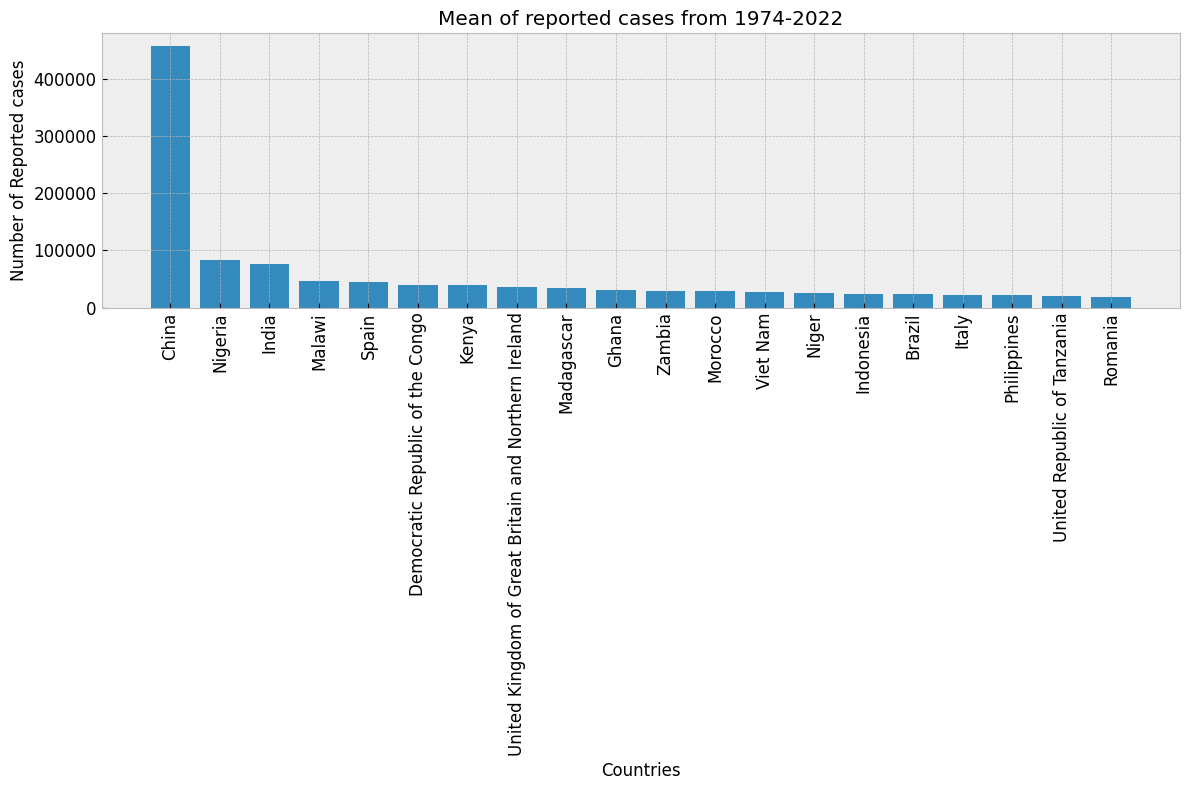

In [80]:
measles_data['Reported_Cases_Mean'] = measles_data.iloc[:, 1:].mean(axis=1)

measles_data_top_mean = measles_data.nlargest(20, 'Reported_Cases_Mean')

plt.figure(figsize=(12, 8))
plt.bar(measles_data_top_mean['Countries, territories and areas'], measles_data_top_mean['Reported_Cases_Mean'])
plt.xlabel('Countries')
plt.ylabel('Number of Reported cases')
plt.title('Mean of reported cases from 1974-2022')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

I wanted to take the mean of all reported cases and display the top 20 countries with the higest data. China ends up at the top by quite a large margin here.

In [81]:
measles_data_top_mean = measles_data.nlargest(50, 'Reported_Cases_Mean')

measles_merged_data = pd.merge(measles_data_top_mean, income_cat, left_on='Countries, territories and areas', right_on='Economy',how='left')

top_countries_income_group = measles_merged_data[['Countries, territories and areas', 'IncomeGroup']]

print(top_countries_income_group)

                     Countries, territories and areas          IncomeGroup
0                                               China  Upper middle income
1                                             Nigeria  Lower middle income
2                                               India  Lower middle income
3                                              Malawi           Low income
4                                               Spain          High income
5                    Democratic Republic of the Congo                  NaN
6                                               Kenya  Lower middle income
7   United Kingdom of Great Britain and Northern I...                  NaN
8                                          Madagascar           Low income
9                                               Ghana  Lower middle income
10                                             Zambia  Lower middle income
11                                            Morocco  Lower middle income
12                       

We have some problems with the countries, territories and areas not lining up name wise. 

In [82]:
missing_income_group = top_countries_income_group[top_countries_income_group['IncomeGroup'].isnull()]
print(missing_income_group)

                     Countries, territories and areas IncomeGroup
5                    Democratic Republic of the Congo         NaN
7   United Kingdom of Great Britain and Northern I...         NaN
12                                           Viet Nam         NaN
18                        United Republic of Tanzania         NaN
28                                            Turkiye         NaN
33                                      Cote d'Ivoire         NaN
36                         Iran (Islamic Republic of)         NaN
39                                              Yemen         NaN
44                 Venezuela (Bolivarian Republic of)         NaN


In [83]:
top_countries_income_group.loc[top_countries_income_group['Countries, territories and areas'] == 'Democratic Republic of the Congo','IncomeGroup'] = 'Low income'
top_countries_income_group.loc[top_countries_income_group['Countries, territories and areas'] == 'United Kingdom of Great Britain and Northern Ireland','IncomeGroup'] = 'High income'
top_countries_income_group.loc[top_countries_income_group['Countries, territories and areas'] == 'Viet Nam','IncomeGroup'] = 'Lower middle income'
top_countries_income_group.loc[top_countries_income_group['Countries, territories and areas'] == 'United Republic of Tanzania','IncomeGroup'] = 'Lower middle income'
top_countries_income_group.loc[top_countries_income_group['Countries, territories and areas'] == 'Turkiye','IncomeGroup'] = 'Upper middle income'
top_countries_income_group.loc[top_countries_income_group['Countries, territories and areas'] == "Cote d'Ivoire",'IncomeGroup'] = 'Lower middle income'
top_countries_income_group.loc[top_countries_income_group['Countries, territories and areas'] == 'Iran (Islamic Republic of)','IncomeGroup'] = 'Lower middle income'
top_countries_income_group.loc[top_countries_income_group['Countries, territories and areas'] == 'Yemen','IncomeGroup'] = 'Low income'
top_countries_income_group.loc[top_countries_income_group['Countries, territories and areas'] == 'Venezuela (Bolivarian Republic of)','IncomeGroup'] = 'Upper middle income'

Resolved the NaN errors due to different naming conventions between datasets.

In [84]:
missing_income_group = top_countries_income_group[top_countries_income_group['IncomeGroup'].isnull()]
print(missing_income_group)

Empty DataFrame
Columns: [Countries, territories and areas, IncomeGroup]
Index: []


In [85]:
measles_income_group_count = top_countries_income_group['IncomeGroup'].value_counts()
print(measles_income_group_count)

IncomeGroup
Lower middle income    20
Low income             13
High income             9
Upper middle income     8
Name: count, dtype: int64


<Axes: xlabel='IncomeGroup', ylabel='Count'>

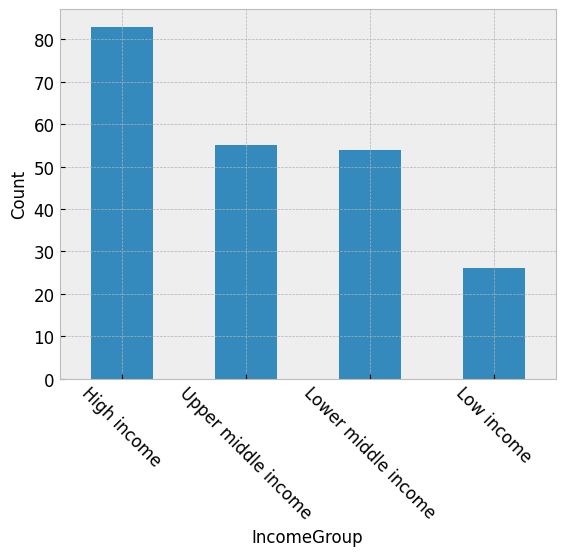

In [86]:
display(income_cat['IncomeGroup'].value_counts().plot(kind='bar', xlabel='IncomeGroup', ylabel='Count', rot=-45))

This is the total count of income groups included in the income_cat dataset

<Axes: xlabel='IncomeGroup', ylabel='Count'>

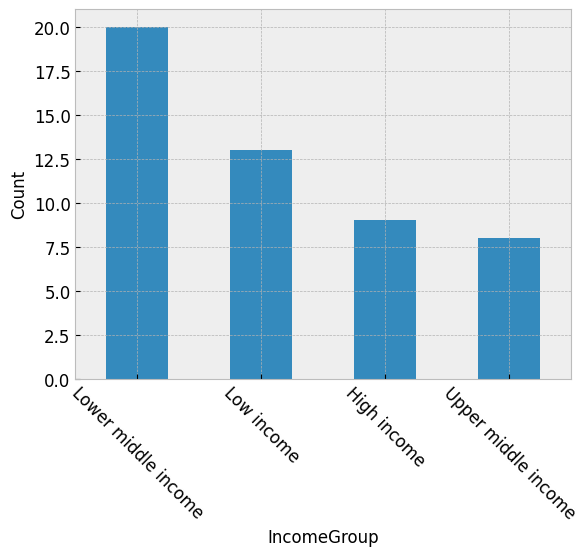

In [87]:
display(measles_income_group_count.plot(kind='bar', xlabel='IncomeGroup', ylabel='Count', rot=-45))

The regular income grouping has 64% of countries listed in the High and Upper middle income. 
The correlated data between income grouping based off of the top 50 measel cases only has 34% of countries listed in the High and Upper middle income. 

<Figure size 1600x1200 with 0 Axes>

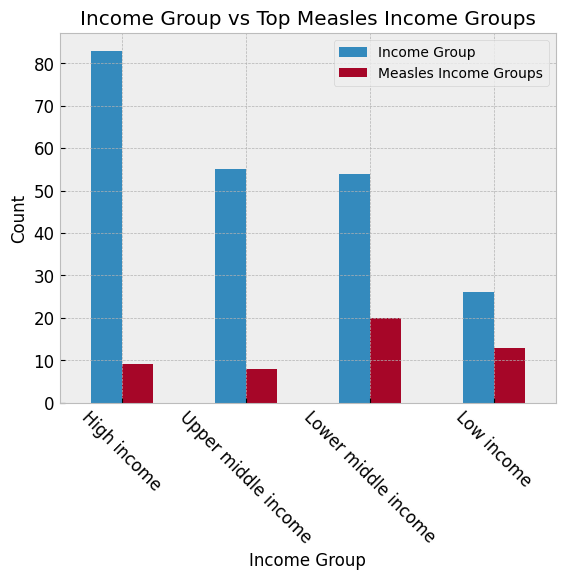

In [92]:
sorted_income_cat = income_cat['IncomeGroup'].value_counts().sort_index()
sorted_income_group_count = measles_income_group_count.sort_index()

combined_income_group = pd.DataFrame({
    'Income Cat': sorted_income_cat,
    'Income Group Count': sorted_income_group_count
})

income_group_order = ['High income', 'Upper middle income', 'Lower middle income', 'Low income']
combined_income_group = combined_income_group.reindex(income_group_order)

plt.figure(figsize=(16, 12)) 
ax = combined_income_group.plot(kind='bar', xlabel='Income Group', ylabel='Count', rot=-45)
plt.xlabel('Income Group')
plt.ylabel('Count')
plt.title('Income Group vs Top Measles Income Groups')
ax.legend(['Income Group', 'Measles Income Groups'])
plt.show()

## Global Burden of Disease Dataset Analysis

This section is the real meat of the final project. I wanted to use some WHO datasets in order to check and see if there was an indication that lower income groups were more greatly impacted against commmunicable diseases. After taking a break, I found that there was a GBD study done in 2019 which analyzed different impacts of communicable diseases on human life and it will be the main dataset that I will be using. 

The income categories were able to be selected but would not designate a country associated with them. So for accurracy there are two different datasets. One that has the country data and one that has the income grouping. I will attempt to join the two with the revised_world_bank_data that I had to create my own dataset from segments of information from world banks website. 

I plan on using both datasets in different graphics but may be able to use them joined for more accurate information.

This data also has two different measures. Deaths is based on the amount of deaths that occured while DALYs (Disability-Adjusted Life Years) are a bit different. 

One DALY represents the loss of the equivalent of one year of full health. DALYs for a disease or health condition are the sum of the years of life lost to due to premature mortality (YLLs) and the years lived with a disability (YLDs) due to prevalent cases of the disease or health condition in a population.

In [93]:
gbd_data_countries.head()

,measure,location,cause,year,val,upper,lower
0,Deaths,Azerbaijan,Other infectious diseases,1990,805.835284,1541.724612,470.218151
1,Deaths,Kuwait,HIV/AIDS and sexually transmitted infections,1990,2.189629,2.396368,1.997354
2,Deaths,Kuwait,Respiratory infections and tuberculosis,1990,224.573964,244.411678,205.859066
3,Deaths,Guyana,Other infectious diseases,1990,61.641865,70.071869,52.412393
4,Deaths,Thailand,Other infectious diseases,1990,7513.721024,10376.482150,5470.150822


In [94]:
income_grouping_data.head()

,location,income
0,Afghanistan,Low income
1,Burkina Faso,Low income
2,Burundi,Low income
3,Central African Republic,Low income
4,Chad,Low income


In [95]:
gbd_merged_data = pd.merge(gbd_data_countries, income_grouping_data, on='location', how='left')

In [96]:
gbd_merged_data.head()

,measure,location,cause,year,val,upper,lower,income
0,Deaths,Azerbaijan,Other infectious diseases,1990,805.835284,1541.724612,470.218151,Upper middle income
1,Deaths,Kuwait,HIV/AIDS and sexually transmitted infections,1990,2.189629,2.396368,1.997354,High income
2,Deaths,Kuwait,Respiratory infections and tuberculosis,1990,224.573964,244.411678,205.859066,High income
3,Deaths,Guyana,Other infectious diseases,1990,61.641865,70.071869,52.412393,High income
4,Deaths,Thailand,Other infectious diseases,1990,7513.721024,10376.482150,5470.150822,Upper middle income


In [97]:
gbd_merged_data.isnull().sum()

measure        0
location       0
cause          0
year           0
val            0
upper          0
lower          0
income      8400
dtype: int64

In [98]:
missing_values = gbd_merged_data[gbd_merged_data['income'].isnull()]
print(missing_values)

                                      measure                     location  \
74                                     Deaths                     Viet Nam   
78                                     Deaths  United Republic of Tanzania   
79                                     Deaths  United Republic of Tanzania   
80                                     Deaths  United Republic of Tanzania   
81                                     Deaths  United Republic of Tanzania   
...                                       ...                          ...   
61158  DALYs (Disability-Adjusted Life Years)          Republic of Moldova   
61159  DALYs (Disability-Adjusted Life Years)          Republic of Moldova   
61183  DALYs (Disability-Adjusted Life Years)          Republic of Moldova   
61184  DALYs (Disability-Adjusted Life Years)          Republic of Moldova   
61195  DALYs (Disability-Adjusted Life Years)          Republic of Moldova   

                                              cause  year      

In [99]:
location_mappings = {
    'Viet Nam': 'Vietnam',
    'United Republic of Tanzania': 'Tanzania',
    'United States Virgin Islands': 'Virgin Islands (U.S.)',
    'Venezuela (Bolivarian Republic of)': 'Venezuela',
    'Slovakia': 'Slovak Republic',
    'Saint Vincent and the Grenadines': 'St. Vincent and the Grenadines',
    'Sao Tome and Principe': 'São Tomé and Principe',
    "Lao People's Democratic Republic": 'Lao PDR',
    "United States of America": 'United States',
    "Democratic People's Republic of Korea": "Korea, Dem. People's Rep",
    "Czechia": "Czech Republic",
    "Micronesia (Federated States of)": "Micronesia, Fed. Sts.",
    "Congo": "Congo, Rep.",
    "Saint Kitts and Nevis": "St. Kitts and Nevis",
    "Taiwan (Province of China)": "Taiwan, China",
    "Saint Lucia": "St. Lucia",
    "Iran (Islamic Republic of)": "Iran, Islamic Rep",
    "Yemen": "Yemen, Rep.",
    "Bolivia (Plurinational State of)": "Bolivia",
    "Turkey": "Türkiye",
    "Bahamas": "Bahamas, The",
    "Democratic Republic of the Congo": "Congo, Dem. Rep",
    "Republic of Moldova": "Moldova",
    
}

for wrong_loc, correct_loc in location_mappings.items():
    gbd_data_countries.loc[gbd_data_countries['location'] == wrong_loc, 'location'] = correct_loc

In [100]:
gbd_merged_data = pd.merge(gbd_data_countries, income_grouping_data, on='location', how='left')

In [101]:
location_ignore = ['Tokelau', 'Cook Islands','Kyrgyzstan', 'Palestine','Niue']

filter_location = gbd_merged_data[~gbd_merged_data['location'].isin(location_ignore)]

missing_values = filter_location[filter_location['income'].isnull()]
print(missing_values)


Empty DataFrame
Columns: [measure, location, cause, year, val, upper, lower, income]
Index: []


These five countries do not have a world bank income level associated with them, so I believe dropping those rows would be best here. 

In [102]:
gbd_merged_data_filtered = gbd_merged_data[~gbd_merged_data['location'].isin(location_ignore)]

gbd_data = gbd_merged_data.drop(gbd_merged_data[gbd_merged_data['location'].isin(location_ignore)].index)

In [103]:
gbd_data.isnull().sum()

measure     0
location    0
cause       0
year        0
val         0
upper       0
lower       0
income      0
dtype: int64

For sake of simplicity, I think it would be best to divide the Deaths and DALY measures into two different datasets since they are different metrics. 

In [104]:
gbd_deaths_data = gbd_data[gbd_data['measure'] == 'Deaths'].copy()
gbd_dalys_data = gbd_data[gbd_data['measure'] == 'DALYs (Disability-Adjusted Life Years)'].copy()

In [105]:
display(gbd_data.shape)
display(gbd_deaths_data.shape)
display(gbd_dalys_data.shape)

(59700, 8)

(29850, 8)

(29850, 8)

In [106]:
display(gbd_deaths_data.head())
display(gbd_dalys_data.head())

,measure,location,cause,year,val,upper,lower,income
0,Deaths,Azerbaijan,Other infectious diseases,1990,805.835284,1541.724612,470.218151,Upper middle income
1,Deaths,Kuwait,HIV/AIDS and sexually transmitted infections,1990,2.189629,2.396368,1.997354,High income
2,Deaths,Kuwait,Respiratory infections and tuberculosis,1990,224.573964,244.411678,205.859066,High income
3,Deaths,Guyana,Other infectious diseases,1990,61.641865,70.071869,52.412393,High income
4,Deaths,Thailand,Other infectious diseases,1990,7513.721024,10376.482150,5470.150822,Upper middle income


,measure,location,cause,year,val,upper,lower,income
30600,DALYs (Disability-Adjusted Life Years),Chile,HIV/AIDS and sexually transmitted infections,1990,8541.744776,9855.810699,7627.036727,High income
30601,DALYs (Disability-Adjusted Life Years),Chile,Respiratory infections and tuberculosis,1990,234432.225700,248461.875500,222505.882200,High income
30602,DALYs (Disability-Adjusted Life Years),Chile,Enteric infections,1990,28619.294720,34136.151180,23900.017870,High income
30603,DALYs (Disability-Adjusted Life Years),Chile,Other infectious diseases,1990,28013.920750,30380.250060,25772.449130,High income
30604,DALYs (Disability-Adjusted Life Years),Uruguay,Neglected tropical diseases and malaria,1990,2026.031702,2817.173438,1379.237618,High income


In [107]:
display(gbd_deaths_data.info())
display(gbd_dalys_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 29850 entries, 0 to 30599
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   measure   29850 non-null  object 
 1   location  29850 non-null  object 
 2   cause     29850 non-null  object 
 3   year      29850 non-null  int64  
 4   val       29850 non-null  float64
 5   upper     29850 non-null  float64
 6   lower     29850 non-null  float64
 7   income    29850 non-null  object 
dtypes: float64(3), int64(1), object(4)
memory usage: 2.0+ MB


None

<class 'pandas.core.frame.DataFrame'>
Index: 29850 entries, 30600 to 61199
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   measure   29850 non-null  object 
 1   location  29850 non-null  object 
 2   cause     29850 non-null  object 
 3   year      29850 non-null  int64  
 4   val       29850 non-null  float64
 5   upper     29850 non-null  float64
 6   lower     29850 non-null  float64
 7   income    29850 non-null  object 
dtypes: float64(3), int64(1), object(4)
memory usage: 2.0+ MB


None

In [108]:
display(gbd_deaths_data.describe())
display(gbd_dalys_data.describe())

,year,val,upper,lower
count,29850.000000,2.985000e+04,2.985000e+04,2.985000e+04
mean,2004.500000,1.053647e+04,1.380237e+04,8.037710e+03
std,8.655586,5.517901e+04,6.876476e+04,4.530573e+04
min,1990.000000,2.774604e-03,6.446965e-03,1.455745e-03
25%,1997.000000,2.554695e+01,3.691669e+01,1.625211e+01
50%,2004.500000,3.766521e+02,5.241258e+02,2.565085e+02
75%,2012.000000,4.895950e+03,6.705248e+03,3.252003e+03
max,2019.000000,1.337168e+06,1.650309e+06,1.203999e+06


,year,val,upper,lower
count,29850.000000,2.985000e+04,2.985000e+04,2.985000e+04
mean,2004.500000,6.590990e+05,8.777666e+05,4.934847e+05
std,8.655586,3.160958e+06,3.904162e+06,2.601945e+06
min,1990.000000,1.600042e+00,2.688603e+00,9.653239e-01
25%,1997.000000,2.741674e+03,3.745740e+03,1.910395e+03
50%,2004.500000,2.724214e+04,3.687157e+04,1.912059e+04
75%,2012.000000,2.958429e+05,4.141435e+05,2.088116e+05
max,2019.000000,7.972402e+07,8.882755e+07,7.056382e+07


The gbd_dalys_data will be utilized mostly for the machine learning section as I hopefully will be able to see the correlation between different countries, the type of communicable disease, and the income of the country. I am unsure of if I will use it for metrics later but I think being able to pick out a country, the type of disease and seeing what income level it correlates to would be cool. 

However, for simplicity and ensuring that I can do some geographs, I will be importing two other datasets that are very similar but include different sections of the data that I can use for this project. 

In [109]:
correlation = gbd_dalys_data['income'].astype('category').cat.codes.corr(gbd_dalys_data['val'])

print(f"Correlation between 'income' and 'val': {correlation}")

Correlation between 'income' and 'val': 0.06921352661382171


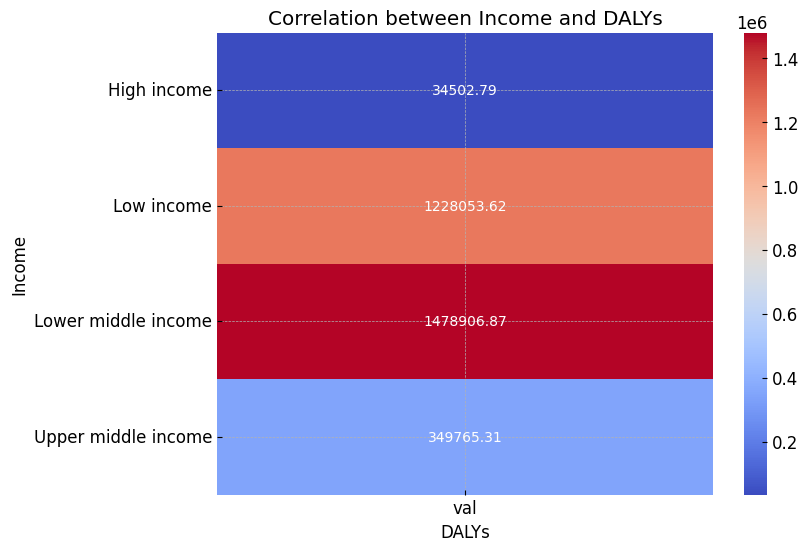

In [143]:
income_mapping = {
    'Lower Income': 1,
    'Lower Middle Income': 2,
    'Upper Middle Income': 3,
    'High Income': 4
}
gbd_dalys_data['Income'] = gbd_dalys_data['income'].map(income_mapping)

correlation = gbd_dalys_data['Income'].corr(gbd_dalys_data['val'])

# Create a pivot table to visualize the correlation
pivot_table = gbd_dalys_data.pivot_table(index='income', values='val', aggfunc='mean')

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Correlation between Income and DALYs')
plt.xlabel('DALYs')
plt.ylabel('Income')
plt.show()

With some help from chatgpt to help me create the correlation heatmap, we can see that low income and lower middle income have a pretty significant correlation with the val or DALYs. 

The gbd_cd_data is a dataset that includes country codes and instead of the more selective communicable disease, it includes everything that the GBD has under the Communicable disease section. 

In [111]:
gbd_cd_data.head()

,Entity,Code,Year,DALYs (Disability-Adjusted Life Years),Income Group
0,Afghanistan,AFG,1990,33619.14,Low income
1,Afghanistan,AFG,1991,30453.39,Low income
2,Afghanistan,AFG,1992,28112.19,Low income
3,Afghanistan,AFG,1993,28650.05,Low income
4,Afghanistan,AFG,1994,29673.50,Low income


In [112]:
gbd_cd_data.shape

(6240, 5)

In [113]:
gbd_cd_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6240 entries, 0 to 6239
Data columns (total 5 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Entity                                  6240 non-null   object 
 1   Code                                    6120 non-null   object 
 2   Year                                    6240 non-null   int64  
 3   DALYs (Disability-Adjusted Life Years)  6240 non-null   float64
 4   Income Group                            6000 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 243.9+ KB


In [114]:
gbd_cd_data.isnull().sum()

Entity                                      0
Code                                      120
Year                                        0
DALYs (Disability-Adjusted Life Years)      0
Income Group                              240
dtype: int64

In [115]:
gbd_cd_data = gbd_cd_data.dropna(subset=['Code', 'Income Group'])

In [116]:
gbd_cd_data.isnull().sum()

Entity                                    0
Code                                      0
Year                                      0
DALYs (Disability-Adjusted Life Years)    0
Income Group                              0
dtype: int64

In [117]:
gbd_cd_data.describe()

,Year,DALYs (Disability-Adjusted Life Years)
count,6000.000000,6000.000000
mean,2004.500000,14842.531665
std,8.656163,18291.803744
min,1990.000000,679.040000
25%,1997.000000,2690.765000
50%,2004.500000,6031.330000
75%,2012.000000,21555.080000
max,2019.000000,89329.480000


In [152]:
fig = px.choropleth(gbd_cd_data, 
                    locations='Code', 
                    color='DALYs (Disability-Adjusted Life Years)', 
                    hover_name='Entity',
                    hover_data=['Income Group'],  
                    color_continuous_scale='Plasma',  
                    title='Disability-Adjusted Life Years by Country') 
fig.update_geos(showcountries=True)  
fig.show() 

I wanted to create a geo graph where you could hover over each country and see the income group it belonged in. This graph allows you to do that as well as see where communicable diseases impact the most. 

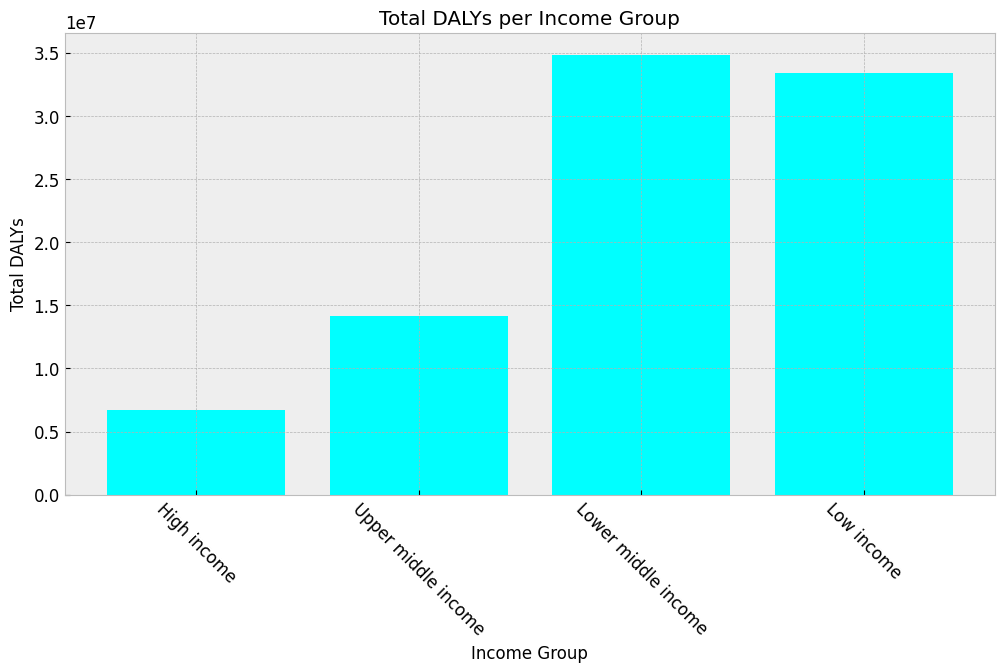

In [121]:
income_group_order = ['High income', 'Upper middle income', 'Lower middle income', 'Low income']

total_dalys_group = gbd_cd_data.groupby('Income Group')['DALYs (Disability-Adjusted Life Years)'].sum().reset_index()

income_group_data = total_dalys_group[total_dalys_group['Income Group'].isin(income_group_order)]
income_group_data['Income Group'] = pd.Categorical(income_group_data['Income Group'], categories=income_group_order, ordered=True)
income_group_data = income_group_data.sort_values('Income Group')

plt.figure(figsize=(12, 6))
plt.bar(income_group_data['Income Group'], income_group_data['DALYs (Disability-Adjusted Life Years)'], color='cyan')
plt.title('Total DALYs per Income Group')
plt.xlabel('Income Group')
plt.ylabel('Total DALYs')
plt.xticks(rotation=-45) 
plt.show()

The total amount of DALYs from High income and Upper middle income areas are significantly less than that of lower middle income and low income. 

In [122]:
print(income_group_data)

          Income Group  DALYs (Disability-Adjusted Life Years)
0          High income                              6696138.09
3  Upper middle income                             14148252.98
2  Lower middle income                             34845364.47
1           Low income                             33365434.45


This graph counts the total DALYs values in each income grouping and plots it as a bar graph. The low income and lower middle income have significantly more total DALYs attributed to them. The High income and Upper middle income only make up 23.4% of the total DALYs

20,844,391.07 / 89,055,189.99 = .234   


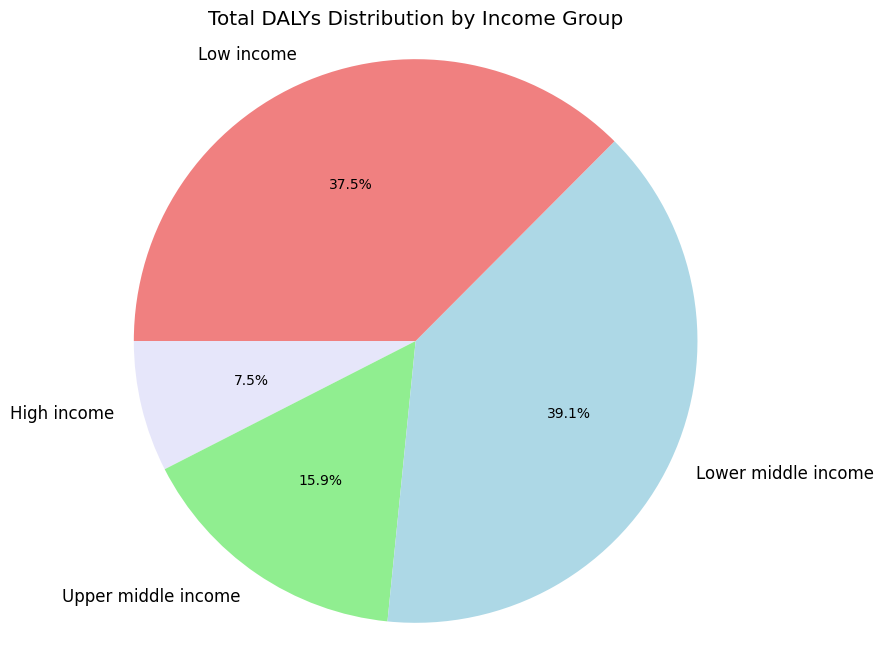

In [123]:
plt.figure(figsize=(8, 8))
plt.pie(income_group_data['DALYs (Disability-Adjusted Life Years)'], labels=income_group_data['Income Group'], autopct='%1.1f%%', colors=['lavender', 'lightgreen', 'lightblue', 'lightcoral'], startangle=180)
plt.title('Total DALYs Distribution by Income Group')
plt.axis('equal') 
plt.show()

The pie chart is a better graphical representation of just how much the Low income and Lower middle income are impacted

## Machine Learning (Regression / Classification)

### EDA

As mentioned earlier, I will mainly be focusing on the Global Burden of Disease datasets taken from a study done in 2019. I plan to utlize these datasets and focus mainly on the DALYs information and the income grouping information. 

Reminder:
One DALY represents the loss of the equivalent of one year of full health. DALYs for a disease or health condition are the sum of the years of life lost to due to premature mortality (YLLs) and the years lived with a disability (YLDs) due to prevalent cases of the disease or health condition in a population.

The dataset provides 5 input variables that are a mixture of continuous/discrete numerical values and ordinal/nominal categories. The complete list of variables is as follows:

Main Dataset - gbd_communicable_diseases.csv

- **Entity**: Nominal Categorical data (Countries and territories).
- **Code**: Nominal Categorical data (Country codes for mapping).
- **Year**: Discrete Numerical data.
- **DALYs (Disability-Adjusted Life Years)**: Continuous Numerical data.
- **Income Group**: Ordinal Categorical Data (Low income, Lower middle income, Upper middle income, High income). 

The data has already been merged and cleaned. Rows with missing values have been dropped or adjusted during the merge. 

The objective is to ultimately be able to select a country and predict whether or not it is heavily impacted by communicable diseases based on its income group. 

### Prepare

In [124]:
gbd_cd_data = pd.read_csv('Data/GBD/gbd_communicable_diseases.csv')

In [125]:
gbd_cd_data.head()

,Entity,Code,Year,DALYs (Disability-Adjusted Life Years),Income Group
0,Afghanistan,AFG,1990,33619.14,Low income
1,Afghanistan,AFG,1991,30453.39,Low income
2,Afghanistan,AFG,1992,28112.19,Low income
3,Afghanistan,AFG,1993,28650.05,Low income
4,Afghanistan,AFG,1994,29673.50,Low income


In [126]:
gbd_cd_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6240 entries, 0 to 6239
Data columns (total 5 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Entity                                  6240 non-null   object 
 1   Code                                    6120 non-null   object 
 2   Year                                    6240 non-null   int64  
 3   DALYs (Disability-Adjusted Life Years)  6240 non-null   float64
 4   Income Group                            6000 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 243.9+ KB


In [127]:
gbd_cd_data.isnull().sum()

Entity                                      0
Code                                      120
Year                                        0
DALYs (Disability-Adjusted Life Years)      0
Income Group                              240
dtype: int64

I dropped the NaN values previously where there was no area code for particular countries using 

In [128]:
gbd_cd_data = gbd_cd_data.dropna(subset=['Code', 'Income Group'])

In [129]:
gbd_cd_data.isnull().sum()

Entity                                    0
Code                                      0
Year                                      0
DALYs (Disability-Adjusted Life Years)    0
Income Group                              0
dtype: int64

In [130]:
display(gbd_cd_data.value_counts('Income Group'))

Income Group
High income            2070
Lower middle income    1560
Upper middle income    1560
Low income              810
Name: count, dtype: int64

<Axes: xlabel='Category', ylabel='Count'>

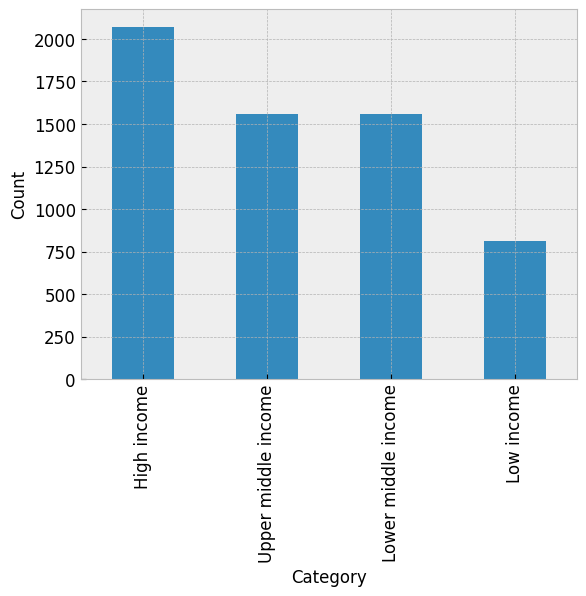

In [131]:
display(gbd_cd_data['Income Group'].value_counts().plot(kind='bar', xlabel='Category', ylabel='Count', rot=90))

I have other visualizations for the data at the end of the checkpoint 2 section. Now I am going to need to split the data

### Prepare

In [132]:
train_set, test_set = train_test_split(gbd_cd_data, test_size=0.2, random_state=50, stratify=gbd_cd_data['Income Group'])

In [133]:
gbd_cd_data_X = train_set.drop('Income Group', axis=1)
gbd_cd_data_y = train_set['Income Group'].copy()

In [134]:
display(gbd_cd_data_X.head())
display(gbd_cd_data_y.head())

,Entity,Code,Year,DALYs (Disability-Adjusted Life Years)
2880,Kuwait,KWT,1990,3159.37
1516,Djibouti,DJI,2006,31901.08
3819,Netherlands,NLD,1999,1515.20
4146,Oman,OMN,1996,5510.62
363,Bahamas,BHS,1993,7396.67


2880            High income
1516    Lower middle income
3819            High income
4146            High income
363             High income
Name: Income Group, dtype: object

### Process

In [135]:
num_features = ['Year','DALYs (Disability-Adjusted Life Years)']
cat_features = ['Entity','Code']

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('standard', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder())
])

full_pipeline = ColumnTransformer([
  ('num', num_pipeline, num_features),
  ('cat', cat_pipeline, cat_features)
])

In [136]:
gbd_cd_data_X_prepared = full_pipeline.fit_transform(gbd_cd_data_X)

### Analyze

In [137]:
dummy_classifier = DummyClassifier(strategy='most_frequent')
dummy_classifier.fit(gbd_cd_data_X_prepared, gbd_cd_data_y)

test_set_X = test_set.drop('Income Group', axis=1)
test_set_X_prepared = full_pipeline.transform(test_set_X)
test_set_y = test_set['Income Group'].copy()

dummy_predictions = dummy_classifier.predict(test_set_X_prepared)

dummy_accuracy = accuracy_score(test_set_y, dummy_predictions)
print(f"Dummy Classifier Accuracy: {dummy_accuracy}")

Dummy Classifier Accuracy: 0.345


In [138]:
models = {
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'SVM': SVC(),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

for name, model in models.items():

    model.fit(gbd_cd_data_X_prepared, gbd_cd_data_y)
    
    test_set_X = test_set.drop('Income Group', axis=1)
    test_set_X_prepared = full_pipeline.transform(test_set_X)
    test_set_y = test_set['Income Group'].copy()
   
    predictions = model.predict(test_set_X_prepared)
    
    accuracy = accuracy_score(test_set_y, predictions)
    
    print(f"{name} Accuracy: {accuracy}")


Decision Tree Accuracy: 0.9891666666666666
Random Forest Accuracy: 1.0
Gradient Boosting Accuracy: 0.985
SVM Accuracy: 1.0
K-Nearest Neighbors Accuracy: 1.0


In [139]:
decision_tree = DecisionTreeClassifier()

decision_tree.fit(gbd_cd_data_X_prepared, gbd_cd_data_y)

test_set_X = test_set.drop('Income Group', axis=1)
test_set_X_prepared = full_pipeline.transform(test_set_X)
test_set_y = test_set['Income Group'].copy()

predictions = decision_tree.predict(test_set_X_prepared)

accuracy = accuracy_score(test_set_y, predictions)
precision = precision_score(test_set_y, predictions, average='weighted')
recall = recall_score(test_set_y, predictions, average='weighted')
f1 = f1_score(test_set_y, predictions, average='weighted')
conf_matrix = confusion_matrix(test_set_y, predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print(conf_matrix)


Accuracy: 0.9891666666666666
Precision: 0.989155780359635
Recall: 0.9891666666666666
F1-score: 0.989150969703795
[[414   0   0   0]
 [  0 158   1   3]
 [  0   2 308   2]
 [  3   0   2 307]]


All models did fantastic against the test data.

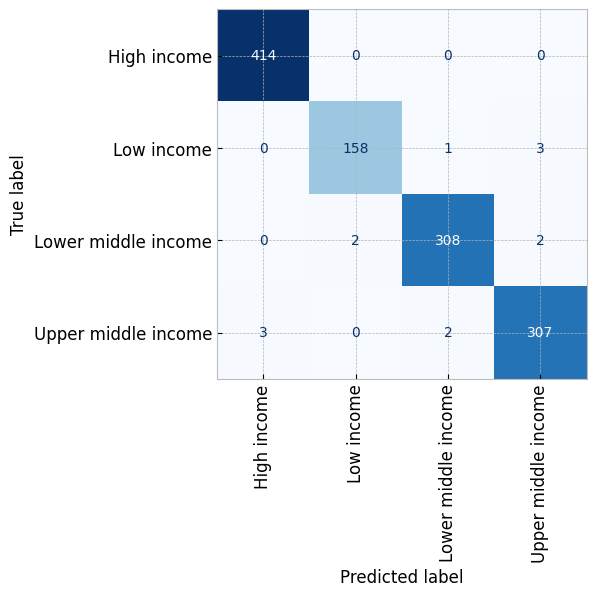

In [140]:
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['High income', 'Low income', 'Lower middle income', 'Upper middle income'])  # Specify your class labels
disp.plot(cmap='Blues', colorbar=False)
plt.xticks(rotation=90)
plt.show()

I want to test it agaist some random data I am going to throw at it and see how accurate it is

In [141]:
test_new_data = pd.DataFrame({
  'Entity': ['Algeria', 'France', 'Mauritania','Somalia', 'South Africa'],
  'Code': ['DZA', 'FRA', 'MRT','SOM', 'ZAF'],
  'Year': [2019, 2012, 2007, 1998, 2019],
  'DALYs (Disability-Adjusted Life Years)': [6024.52, 4302.32, 29910.86, 68484.04, 23778.37],
})

actual_income_group = ['Lower middle income', 'High income', 'Lower middle income', 'Low income','Upper middle income']

test_new_data_prepared = full_pipeline.transform(test_new_data)
decision_tree.fit(gbd_cd_data_X_prepared, gbd_cd_data_y)
new_data_predictions = decision_tree.predict(test_new_data_prepared)

for entity, actual_group, prediction in zip(test_new_data['Entity'], actual_income_group, new_data_predictions):
    print(f"{entity}: Actual Income Group - {actual_group}, Predicted Income Group - {prediction}")

Algeria: Actual Income Group - Lower middle income, Predicted Income Group - Lower middle income
France: Actual Income Group - High income, Predicted Income Group - Upper middle income
Mauritania: Actual Income Group - Lower middle income, Predicted Income Group - Lower middle income
Somalia: Actual Income Group - Low income, Predicted Income Group - Low income
South Africa: Actual Income Group - Upper middle income, Predicted Income Group - Upper middle income


Due to the relatively high correlation betwen a high DALYs and Income grouping which was explored in the visualization section, the machine learning models performed exceptionally well on the data. The models were extremely accurate at predicting the Income grouping based on the DALYs values given.

This would be relatively accurate at predicting data in the future. However, as the DALYs are becoming smaller and smaller, wer would probably have to focus on more recent data due to a decrease in DALYs due to greater health awareness and vaccinations around the globe. 

This is still an extremely important topic as it is often the lower income countries who struggle the most and are impacted the worst by communicable diseases. Fotunately we have made fantastic progress overtime as DALYs values have decreased tremendously over the past few years compared to what they were a decade ago

## Resources and References


- https://apps.who.int/gho/data/node.main
- https://datacatalog.worldbank.org/
- https://www.healthdata.org/
- https://ourworldindata.org/burden-of-disease


- https://plotly.com/python/choropleth-maps/
- https://datatopics.worldbank.org/world-development-indicators/the-world-by-income-and-region.html
- https://realpython.com/pandas-merge-join-and-concat/
- https://pandas.pydata.org/pandas-docs/stable/index.html
- https://stackabuse.com/overview-of-classification-methods-in-python-with-scikit-learn/
- https://realpython.com/train-test-split-python-data/


- ChatGPT

In [5]:
# ⚠️ Make sure you run this cell at the end of your notebook before every submission!
!jupyter nbconvert --to python source.ipynb

[NbConvertApp] Converting notebook source.ipynb to python
[NbConvertApp] Writing 37651 bytes to source.py
